## Libraries

In [1]:
import os
import cv2
import json
import pickle
import random
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.models as models
import torchvision.transforms as transforms

from pathlib import Path
from datetime import datetime as dt
from functools import partial
from collections import Counter, defaultdict

from PIL import Image

from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from fastprogress import master_bar, progress_bar

pd.options.display.max_columns = 128
torch.multiprocessing.set_start_method("spawn")

## Data Loading

In [2]:
input_dir = Path("../input/petfinder-adoption-prediction/")
train = pd.read_csv(input_dir / "train/train.csv")
test = pd.read_csv(input_dir / "test/test.csv")
sample_submission = pd.read_csv(input_dir / "test/sample_submission.csv")

train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

In [3]:
train.PhotoAmt.mean(), test.PhotoAmt.mean()

(3.889214966984593, 3.8095238095238093)

## Image model loading

In [4]:
!cp ../input/pytorch-pretrained-image-models/* ./
!ls 

__notebook_source__.ipynb  densenet201.pth  resnet50.pth
densenet121.pth		   resnet34.pth


## Metadata and Sentiment data

In [5]:
def jopen(path):
    with open(path, "r", encoding="utf-8") as f:
        json_file = json.load(f)
    return json_file


def parse_sentiment_file(path):
    file = jopen(path)
    language: str = file["language"]

    sentiment: list = file["documentSentiment"]
    entities: list = [x["name"] for x in file["entities"]]
    entity = " ".join(entities)

    sentence_sentiment: list = [x["sentiment"] for x in file["sentences"]]
    magnitude: np.ndarray = np.array(
        [x["magnitude"] for x in sentence_sentiment])
    score: np.ndarray = np.array([x["score"] for x in sentence_sentiment])

    return_js = {
        "magnitude_sum": magnitude.sum(),
        "magnitude_mean": magnitude.mean(),
        "magnitude_var": magnitude.var(),
        "score_sum": score.sum(),
        "score_mean": score.mean(),
        "score_var": score.var(),
        "language": language,
        "entity": entity,
        "document_magnitude": sentiment["magnitude"],
        "document_score": sentiment["score"]
    }
    return return_js


def parse_metadata(path):
    file: dict = jopen(path)
    file_keys = list(file.keys())
    name_specified = 0
    if "labelAnnotations" in file_keys:
        file_annots = file["labelAnnotations"]
        file_mean_score = np.asarray([x["score"] for x in file_annots]).mean()
        file_desc = " ".join([x["description"] for x in file_annots])
        if "cat" in file_desc or "dog" in file_desc:
            name_specified = 1
    else:
        file_mean_score = np.nan
        file_desc = ""

    file_colors: list = file["imagePropertiesAnnotation"]["dominantColors"][
        "colors"]
    file_crops: list = file["cropHintsAnnotation"]["cropHints"]

    color_score = np.asarray([x["score"] for x in file_colors]).mean()
    pixel_frac = np.asarray([x["pixelFraction"] for x in file_colors]).mean()
    crop_conf = np.asarray([x["confidence"] for x in file_crops]).mean()

    if "importanceFraction" in file_crops[0].keys():
        crop_importance = np.asarray(
            [x["importanceFraction"] for x in file_crops]).mean()
    else:
        crop_importance = np.nan
    metadata = {
        "annot_score": file_mean_score,
        "color_score": color_score,
        "pixel_frac": pixel_frac,
        "crop_conf": crop_conf,
        "crop_importance": crop_importance,
        "desc": file_desc,
        "specified": name_specified
    }
    return metadata


def additinal_features_per_id(pet_id, sentiment_path: Path, meta_path: Path):
    sentiment_path = sentiment_path / f"{pet_id}.json"
    try:
        sentiment = parse_sentiment_file(sentiment_path)
        sentiment["pet_id"] = pet_id
    except FileNotFoundError:
        sentiment = {}

    meta_files = sorted(meta_path.glob(f"{pet_id}*.json"))
    metadata_list = []
    if len(meta_files) > 0:
        for f in meta_files:
            metadata = parse_metadata(f)
            metadata["pet_id"] = pet_id
            metadata_list.append(metadata)
    return sentiment, metadata_list


def load_additional_features(ped_ids: list, sentiment_path: Path,
                             meta_path: Path):
    features = Parallel(
        n_jobs=-1, verbose=1)(
            delayed(additinal_features_per_id)(i, sentiment_path, meta_path)
            for i in ped_ids)
    sentiments = [x[0] for x in features if len(x[0]) > 0]
    metadatas = [x[1] for x in features if len(x[1]) > 0]
    sentiment_keys = sentiments[0].keys()
    metadata_keys = metadatas[0][0].keys()
    sentiment_dict = {}
    metadata_dict = {}
    for key in sentiment_keys:
        sentiment_dict[key] = [x[key] for x in sentiments]

    for key in metadata_keys:
        meta_list = []
        for meta_per_pid in metadatas:
            meta_list += [meta[key] for meta in meta_per_pid]
        metadata_dict[key] = meta_list

    sentiment_df = pd.DataFrame(sentiment_dict)
    metadata_df = pd.DataFrame(metadata_dict)
    return sentiment_df, metadata_df


def aggregate_metadata(metadata_df: pd.DataFrame,
                       aggregates=["sum", "mean", "var"]):
    meta_desc: pd.DataFrame = metadata_df.groupby(["pet_id"])["desc"].unique()
    meta_desc = meta_desc.reset_index()
    meta_desc["desc"] = meta_desc["desc"].apply(lambda x: " ".join(x))

    meta_gr: pd.DataFrame = metadata_df.drop(["desc"], axis=1)
    for i in meta_gr.columns:
        if "pet_id" not in i:
            meta_gr[i] = meta_gr[i].astype(float)
    meta_gr = meta_gr.groupby(["pet_id"]).agg(aggregates)
    meta_gr.columns = pd.Index(
        [f"{c[0]}_{c[1].upper()}" for c in meta_gr.columns.tolist()])
    meta_gr = meta_gr.reset_index()
    return meta_gr, meta_desc


def aggregate_sentiment(sentiment_df: pd.DataFrame, aggregates=["sum"]):
    sentiment_desc: pd.DataFrame = sentiment_df.groupby(
        ["pet_id"])["entity"].unique()
    sentiment_desc = sentiment_desc.reset_index()
    sentiment_desc["entity"] = sentiment_desc["entity"].apply(
        lambda x: " ".join(x))
    sentiment_lang = sentiment_df.groupby(
        ["pet_id"])["language"].unique()
    sentiment_lang = sentiment_lang.reset_index()
    sentiment_lang["language"] = sentiment_lang["language"].apply(
        lambda x: " ".join(x))
    sentiment_desc = sentiment_desc.merge(
        sentiment_lang, how="left", on="pet_id")
    

    sentiment_gr: pd.DataFrame = sentiment_df.drop(["entity", "language"],
                                                   axis=1)
    for i in sentiment_gr.columns:
        if "pet_id" not in i:
            sentiment_gr[i] = sentiment_gr[i].astype(float)
    sentiment_gr = sentiment_gr.groupby(["pet_id"]).agg(aggregates)
    sentiment_gr.columns = pd.Index(
        [f"{c[0]}" for c in sentiment_gr.columns.tolist()])
    sentiment_gr = sentiment_gr.reset_index()
    return sentiment_gr, sentiment_desc

## Load data

In [6]:
input_dir = Path("../input/petfinder-adoption-prediction/")
train = pd.read_csv(input_dir / "train/train.csv")
test = pd.read_csv(input_dir / "test/test.csv")
sample_submission = pd.read_csv(input_dir / "test/sample_submission.csv")

In [7]:
sp_train = input_dir / Path("train_sentiment/")
mp_train = input_dir / Path("train_metadata/")
sp_test = input_dir / Path("test_sentiment/")
mp_test = input_dir / Path("test_metadata/")

In [8]:
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

In [9]:
train_sentiment_df, train_metadata_df = load_additional_features(
    train_pet_ids, sp_train, mp_train)

test_sentiment_df, test_metadata_df = load_additional_features(
    test_pet_ids, sp_test, mp_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 11246 tasks      |

## Aggregate sentiment data and metadata

In [10]:
train_meta_gr, train_meta_desc = aggregate_metadata(train_metadata_df)
test_meta_gr, test_meta_desc = aggregate_metadata(test_metadata_df)
train_sentiment_gr, train_sentiment_desc = \
    aggregate_sentiment(train_sentiment_df)
test_sentiment_gr, test_sentiment_desc = \
    aggregate_sentiment(test_sentiment_df)

## Merge processed DataFrames with base train/test DataFrame

In [11]:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how="left", left_on="PetID", right_on="pet_id")
train_proc = train_proc.merge(
    train_meta_gr, how="left", left_on="PetID", right_on="pet_id")
train_proc = train_proc.merge(
    train_sentiment_desc, how="left", left_on="PetID", right_on="pet_id")
train_proc = train_proc.merge(
    train_meta_desc, how="left", left_on="PetID", right_on = "pet_id")

test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how="left", left_on="PetID", right_on="pet_id")
test_proc = test_proc.merge(
    test_meta_gr, how="left", left_on="PetID", right_on="pet_id")
test_proc = test_proc.merge(
    test_sentiment_desc, how="left", left_on="PetID", right_on="pet_id")
test_proc = test_proc.merge(
    test_meta_desc, how="left", left_on="PetID", right_on = "pet_id")

In [12]:
print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 57) (3948, 56)


In [13]:
train_proc.drop(train_proc.filter(
    regex="pet_id", axis=1).columns.tolist(), 
    axis=1, 
    inplace=True)

test_proc.drop(test_proc.filter(
    regex="pet_id", axis=1).columns.tolist(),
    axis=1,
    inplace=True)

train_proc.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,entity,language,desc
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN,1.0,1.0,NaN,Nibble cuteness clinic cats result kitty coupl...,en,cat black cat small to medium sized cats cat l...
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,apartment care,en,cat whiskers small to medium sized cats fauna ...
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,mother owner puppies roadside shops Subang Jay...,en,dog dog like mammal dog breed dog breed group ...
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.9,0.900000,0.000000,0.9,0.900000,0.000000,0.9,0.9,6.045986,0.755748,0.000221,0.660390,0.082549,0.000278,0.548335,0.068542,0.000571,6.4,0.8,0.0,8.00,1.000000,0.000000,8.0,1.0,0.0,guard dog master obedience call sms details,en,dog dog like mammal dog breed dog breed group ...
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,3.5,0.583333,0.071389,3.5,0.583333,0.071389,3.7,0.6,2.326006,0.775335,0.011257,0.239312,0.079771,0.000075,0.128066,0.042689,0.000016,2.4,0.8,0.0,2.98,0.993333,0.000133,3.0,1.0,0.0,boy adoption Hunter pal puppies love age brat ...,en,dog dog like mammal dog breed puppy mammal dog...


In [14]:
train_proc.language.fillna("", inplace=True)
test_proc.language.fillna("", inplace=True)

langs = train_proc.language.unique()
encode_dict = {k: i for i, k in enumerate(langs)}

train_proc.language = train_proc.language.map(encode_dict)
test_proc.language = test_proc.language.map(encode_dict)

## Add Breed Mapping

In [15]:
labels_breed = pd.read_csv("../input/petfinder-adoption-prediction/breed_labels.csv")
labels_state = pd.read_csv("../input/petfinder-adoption-prediction/state_labels.csv")
labels_color = pd.read_csv("../input/petfinder-adoption-prediction/color_labels.csv")

In [16]:
train_breed_main = train_proc[["Breed1"]].merge(
    labels_breed, how="left",
    left_on="Breed1", right_on="BreedID",
    suffixes=("", "_main_breed"))
train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix("main_breed_")

train_breed_second = train_proc[["Breed2"]].merge(
    labels_breed, how="left",
    left_on="Breed2", right_on="BreedID",
    suffixes=("", "_second_breed"))
train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix("second_breed_")

train_proc = pd.concat([
    train_proc, train_breed_main, train_breed_second
], axis=1)

test_breed_main = test_proc[["Breed1"]].merge(
    labels_breed, how="left",
    left_on="Breed1", right_on="BreedID",
    suffixes=("", "_main_breed"))
test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix("main_breed_")

test_breed_second = test_proc[["Breed2"]].merge(
    labels_breed, how="left",
    left_on="Breed2", right_on="BreedID",
    suffixes=("", "_second_breed"))
test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix("second_breed_")

test_proc = pd.concat([
    test_proc, test_breed_main, test_breed_second
], axis=1)

print(train_proc.shape, test_proc.shape)
train_proc.head()

(14993, 57) (3948, 56)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,entity,language,desc,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN,1.0,1.0,NaN,Nibble cuteness clinic cats result kitty coupl...,0,cat black cat small to medium sized cats cat l...,2.0,Tabby,NaN,NaN
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,apartment care,0,cat whiskers small to medium sized cats fauna ...,2.0,Domestic Medium Hair,NaN,NaN
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,mother owner puppies roadside shops Subang Jay...,0,dog dog like mammal dog breed dog breed group ...,1.0,Mixed Breed,NaN,NaN
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.9,0.900000,0.000000,0.9,0.900000,0.000000,0.9,0.9,6.045986,0.755748,0.000221,0.660390,0.082549,0.000278,0.548335,0.068542,0.000571,6.4,0.8,0.0,8.00,1.000000,0.000000,8.0,1.0,0.0,guard dog master obedience call sms details,0,dog dog like mammal dog breed dog breed group ...,1.0,Mixed Breed,NaN,NaN
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,3.5,0.583333,0.071389,3.5,0.583333,0.071389,3.7,0.6,2.326006,0.775335,0.011257,0.239312,0.079771,0.000075,0.128066,0.042689,0.000016,2.4,0.8,0.0,2.98,0.993333,0.000133,3.0,1.0,0.0,boy adoption Hunter pal puppies love age brat ...,0,dog dog like mammal dog breed puppy mammal dog...,1.0,Mixed Breed,NaN,NaN


## Feature engineering

In [17]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
X_temp = X.copy()

text_columns = [
    "Description",
    "entity",
    "desc"]
categorical_columns = [
    "Type", "Breed1", "Breed2", "Gender",
    "Color1", "Color2", "Color3", "MaturitySize",
    "FurLength", "Vaccinated", "Dewormed", "Sterilized",
    "State", "language", "main_breed_BreedName", "second_breed_BreedName"
]
cat_c = ["main_breed_BreedName", "second_breed_BreedName"]
drop_columns = [
    "PetID", "Name", "RescuerID"
]

In [18]:
for i in cat_c:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [19]:
X_text = X_temp[text_columns]
for i in X_text.columns:
    X_text[i] = X_text[i].fillna("none")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
X_temp["len_description"] = X_text["Description"].map(len)
X_temp["len_meta_desc"] = X_text["desc"].map(len)
X_temp["len_entity"] = X_text["entity"].map(len)

In [21]:
import re

from nltk.corpus import stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.tokenize import RegexpTokenizer
import nltk.stem as stm
from nltk import WordNetLemmatizer, word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

Using TensorFlow backend.


In [22]:
X_text["cleaned_text"] = X_text["Description"].map(lambda x: x.lower())
X_text["cleaned_text"] = X_text["cleaned_text"].map(lambda x: clean_text(x))
X_text["cleaned_text"] = X_text["cleaned_text"].map(lambda x: clean_numbers(x))
X_text["cleaned_text"] = X_text["cleaned_text"].map(lambda x: replace_typical_misspell(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [23]:
eng_stopwords = set(stopwords.words("english"))
import string

X_temp["len_description"] = X_text["Description"].map(len)
X_temp["len_meta_desc"] = X_text["desc"].map(len)
X_temp["len_entity"] = X_text["entity"].map(len)

X_temp["num_description_words"] = X_text["Description"].map(lambda x: len(str(x).split()))
X_temp["num_desc_words"] = X_text["desc"].map(lambda x: len(str(x).split()))
X_temp["num_entity_words"] = X_text["entity"].map(lambda x: len(str(x).split()))

X_temp["uniq_description_words"] = X_text["Description"].map(lambda x: len(set(str(x).split())))
X_temp["uniq_desc_words"] = X_text["desc"].map(lambda x: len(set(str(x).split())))
X_temp["uniq_entity_words"] = X_text["entity"].map(lambda x: len(set(str(x).split())))

X_temp["num_description_stopwords"] = X_text["Description"].map(lambda x: len([
    w for w in str(x).lower().split() if w in eng_stopwords]))
X_temp["num_desc_stopwords"] = X_text["desc"].map(lambda x: len([
    w for w in str(x).lower().split() if w in eng_stopwords]))
X_temp["num_entity_stopwords"] = X_text["entity"].map(lambda x: len([
    w for w in str(x).lower().split() if w in eng_stopwords]))

X_temp["num_description_punctuation"] = X_text["Description"].map(lambda x: len([
    c for c in str(x) if c in string.punctuation]))

### State stats

In [24]:
state_gdp = {
    41336: 116.679,
    41325: 40.596,
    41367: 23.02,
    41401: 190.075,
    41415: 5.984,
    41324: 37.274,
    41332: 42.389,
    41335: 52.452,
    41330: 67.629,
    41380: 5.642,
    41327: 81.284,
    41345: 80.167,
    41342: 121.414,
    41326: 280.698,
    41361: 32.270
}

state_population = {
    41336: 33.48283,
    41325: 19.47651,
    41367: 15.39601,
    41401: 16.74621,
    41415: 0.86908,
    41324: 8.21110,
    41332: 10.21064,
    41335: 15.00817,
    41330: 23.52743,
    41380: 2.31541,
    41327: 15.61383,
    41345: 32.06742,
    41342: 24.71140,
    41326: 54.62141,
    41361: 10.35977
}

state_area ={
    41336:19102,
    41325:9500,
    41367:15099,
    41401:243,
    41415:91,
    41324:1664,
    41332:6686,
    41335:36137,
    41330:21035,
    41380:821,
    41327:1048,
    41345:73631,
    41342:124450,
    41326:8104,
    41361:13035
}
X_temp["state_gdp"] = X_temp.State.map(state_gdp)
X_temp["state_population"] = X_temp.State.map(state_population)
X_temp["state_area"] = X_temp.State.map(state_area)

X_temp["state_gdp_per_person"] = X_temp["state_gdp"] / X_temp["state_population"] * 1e4
X_temp["fee_per_gdp_per_person"] = X_temp.Fee / X_temp["state_gdp_per_person"]

In [25]:
X_temp.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,entity,language,desc,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN,1.0,1.0,NaN,Nibble cuteness clinic cats result kitty coupl...,0,cat black cat small to medium sized cats cat l...,2.0,0,NaN,-1,359,111,86,69,19,13,57,16,12,34,1,0,8,280.698,54.62141,8104,51389.738932,0.001946
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,apartment care,0,cat whiskers small to medium sized cats fauna ...,2.0,1,NaN,-1,118,212,14,23,37,2,20,21,2,12,2,0,2,190.075,16.74621,243,113503.294178,0.000000
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,mother owner puppies roadside shops Subang Jay...,0,dog dog like mammal dog breed dog breed group ...,1.0,2,NaN,-1,393,855,98,69,135,15,60,24,14,30,0,0,9,280.698,54.62141,8104,51389.738932,0.000000
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2.0,0.9,0.900000,0.000000,0.9,0.900000,0.000000,0.9,0.9,6.045986,0.755748,0.000221,0.660390,0.082549,0.000278,0.548335,0.068542,0.000571,6.4,0.8,0.0,8.00,1.000000,0.000000,8.0,1.0,0.0,guard dog master obedience call sms details,0,dog dog like mammal dog breed dog breed group ...,1.0,2,NaN,-1,146,879,43,25,141,7,24,21,7,8,0,0,7,190.075,16.74621,243,113503.294178,0.001322
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2.0,3.5,0.583333,0.071389,3.5,0.583333,0.071389,3.7,0.6,2.326006,0.775335,0.011257,0.239312,0.079771,0.000075,0.128066,0.042689,0.000016,2.4,0.8,0.0,2.98,0.993333,0.000133,3.0,1.0,0.0,boy adoption Hunter pal puppies love age brat ...,0,dog dog like mammal dog breed puppy mammal dog...,1.0,2,NaN,-1,390,312,77,81,49,13,65,19,13,42,0,0,9,280.698,54.62141,8104,51389.738932,0.000000


### Name features

In [26]:
import re
def has_name(x):
    if isinstance(x, float):
        return 0
    if "no name" in x.lower():
        return 0
    return 1


def num_name_words(x):
    if isinstance(x, float):
        return 0
    name_words = x.split(" ")
    return len(name_words)


def contains_amp(x):
    if isinstance(x, float):
        return 0
    if "&" in x:
        return 1
    if "and" in x.lower():
        return 1
    if "+" in x.lower():
        return 1
    return 0


def contains_comma(x):
    if isinstance(x, float):
        return 0
    if "," in x:
        return 1
    return 0


def start_with_number(x):
    if isinstance(x, float):
        return 0
    match = re.match(f"\d", x)
    if match:
        return int(match.group())
    return 0


def contains_paren(x):
    if isinstance(x, float):
        return 0
    if "(" in x:
        return 1
    if ")" in x:
        return 1
    return 0


def contains_number(x):
    if isinstance(x, float):
        return 0
    if re.match(r".*\d", x):
        return 1
    return 0


def safe_calc_len(x):
    if isinstance(x, float):
        return 1
    return len(x)


def num_unlike_letters(x):
    if isinstance(x, float):
        return 0
    letters = {
        ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', 
        '&', '/', '[', ']', '>', '%', '=', '#', '*', '+',  
        '•',  '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',
        '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 
        'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', 
        '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', 
        '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', 
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', 
        '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', 
        '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', 
        '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', "ã", "ç", "å", "ä",
        "¶", "ð"}

    letter_in = set(x)
    intersection = letter_in.intersection(letters)
    if len(intersection) == 0:
        return 0
    else:
        unlike_num = 0
        for l in intersection:
            unlike_num += len(re.findall(re.escape(l), x))
        return unlike_num

X_temp["num_name_words"] = X_temp.Name.map(lambda x: num_name_words(x))
X_temp["contains_amp"] = X_temp.Name.map(lambda x: contains_amp(x))
X_temp["contains_comma"] = X_temp.Name.map(lambda x: contains_comma(x))
X_temp["start_with_number"] = X_temp.Name.map(lambda x: start_with_number(x))
X_temp["contains_paren"] = X_temp.Name.map(lambda x: contains_paren(x))
X_temp["contains_number"] = X_temp.Name.map(lambda x: contains_number(x))
X_temp["name_length"] = X_temp.Name.map(lambda x: safe_calc_len(x))
X_temp["num_unlike_letters"] = X_temp.Name.map(lambda x: num_unlike_letters(x))
X_temp["rate_unlike_letters"] = X_temp.num_unlike_letters / X_temp.name_length
X_temp.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,entity,language,desc,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN,1.0,1.0,NaN,Nibble cuteness clinic cats result kitty coupl...,0,cat black cat small to medium sized cats cat l...,2.0,0,NaN,-1,359,111,86,69,19,13,57,16,12,34,1,0,8,280.698,54.62141,8104,51389.738932,0.001946,1,0,0,0,0,0,6,0,0.0
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,apartment care,0,cat whiskers small to medium sized cats fauna ...,2.0,1,NaN,-1,118,212,14,23,37,2,20,21,2,12,2,0,2,190.075,16.74621,243,113503.294178,0.000000,3,0,0,0,0,0,11,0,0.0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,mother owner puppies roadside shops Subang Jay...,0,dog dog like mammal dog breed dog breed group ...,1.0,2,NaN,-1,393,855,98,69,135,15,60,24,14,30,0,0,9,280.698,54.62141,8104,51389.738932,0.000000,1,0,0,0,0,0,6,0,0.0
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2.0,0.9,0.900000,0.000000,0.9,0.900000,0.000000,0.9,0.9,6.045986,0.755748,0.000221,0.660390,0.082549,0.000278,0.548335,0.068542,0.000571,6.4,0.8,0.0,8.00,1.000000,0.000000,8.0,1.0,0.0,guard dog master obedience call sms details,0,dog dog like mammal dog breed dog breed group ...,1.0,2,NaN,-1,146,879,43,25,141,7,24,21,7,8,0,0,7,190.075,16.74621,243,113503.294178,0.001322,1,0,0,0,0,0,4,0,0.0
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2.0,3.5,0.583333,0.071389,3.5,0.583333,0.071389,3.7,0.6,2.326006,0.775335,0.011257,0.239312,0.079771,0.000075,0.128066,0.042689,0.000016,2.4,0.8,0.0,2.98,0.993333,0.000133,3.0,1.0,0.0,boy adoption Hunter pal puppies love age brat ...,0,dog dog like mammal dog breed puppy mammal dog...,1.0,2,NaN,-1,390,312,77,81,49,13,65,19,13,42,0,0,9,280.698,54.62141,8104,51389.738932,0.000000,1,0,0,0,0,0,6,0,0.0


## Tfidf

In [27]:
n_components = 16
text_features = []

for i in text_columns:
    print(f"generating features from: {i}")
    tfv = TfidfVectorizer(
        min_df=2,
        strip_accents="unicode",
        analyzer="word",
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=(1, 3),
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1)
    svd = TruncatedSVD(
        n_components=n_components,
        random_state=1337)
    tfidf_col = tfv.fit_transform(X_text.loc[:, i].values)
    svd_col = svd.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix("Tfidf_{}_".format(i))
    
    text_features.append(svd_col)

text_features = pd.concat(text_features, axis=1)
X_temp = pd.concat([X_temp, text_features], axis=1)

for i in text_columns:
    X_temp.drop(i, axis=1, inplace=True)

generating features from: Description
generating features from: entity
generating features from: desc


## Image size features

In [28]:
import os
import glob

train_image_files = sorted(
    glob.glob("../input/petfinder-adoption-prediction/train_images/*.jpg"))
test_image_files = sorted(
    glob.glob("../input/petfinder-adoption-prediction/test_images/*.jpg"))

train_df_imgs = pd.DataFrame(train_image_files)
test_df_imgs = pd.DataFrame(test_image_files)
train_df_imgs.columns = ["image_file_name"]
test_df_imgs.columns = ["image_file_name"]

train_imgs_pets = train_df_imgs["image_file_name"].apply(
    lambda x: x.split("/")[-1].split("-")[0])
test_imgs_pets = test_df_imgs["image_file_name"].apply(
    lambda x: x.split("/")[-1].split("-")[0])
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

def get_size(filename):
    st = os.stat(filename)
    return st.st_size

def get_dimensions(filename):
    img_size = Image.open(filename).size
    return img_size

train_df_imgs["image_size"] = train_df_imgs["image_file_name"].apply(get_size)
test_df_imgs["image_size"] = test_df_imgs["image_file_name"].apply(get_size)
train_df_imgs["temp_size"] = train_df_imgs["image_file_name"].apply(get_dimensions)
test_df_imgs["temp_size"] = test_df_imgs["image_file_name"].apply(get_dimensions)
train_df_imgs["width"] = train_df_imgs["temp_size"].apply(lambda x: x[0])
test_df_imgs["width"] = test_df_imgs["temp_size"].apply(lambda x: x[0])
train_df_imgs["height"] = train_df_imgs["temp_size"].apply(lambda x: x[1])
test_df_imgs["height"] = test_df_imgs["temp_size"].apply(lambda x: x[1])
train_df_imgs.drop(["temp_size"], axis=1, inplace=True)
test_df_imgs.drop(["temp_size"], axis=1, inplace=True)

aggs = {
    "image_size": ["sum", "mean", "var"],
    "width": ["sum", "mean", "var"],
    "height": ["sum", "mean", "var"]
}
agg_train_imgs = train_df_imgs.groupby("PetID").agg(aggs)
new_columns = [
    k + "_" + agg for k in aggs.keys() for agg in aggs[k]
]
agg_test_imgs = test_df_imgs.groupby("PetID").agg(aggs)
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()


In [29]:
agg_imgs = pd.concat([agg_train_imgs, agg_test_imgs], axis=0).reset_index(drop=True)
X_temp = X_temp.merge(agg_imgs, how="left", on="PetID")
X_temp.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,language,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,...,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,Tfidf_Description_5,Tfidf_Description_6,Tfidf_Description_7,Tfidf_Description_8,Tfidf_Description_9,Tfidf_Description_10,Tfidf_Description_11,Tfidf_Description_12,Tfidf_Description_13,Tfidf_Description_14,Tfidf_Description_15,Tfidf_entity_0,Tfidf_entity_1,Tfidf_entity_2,Tfidf_entity_3,Tfidf_entity_4,Tfidf_entity_5,Tfidf_entity_6,Tfidf_entity_7,Tfidf_entity_8,Tfidf_entity_9,Tfidf_entity_10,Tfidf_entity_11,Tfidf_entity_12,Tfidf_entity_13,Tfidf_entity_14,Tfidf_entity_15,Tfidf_desc_0,Tfidf_desc_1,Tfidf_desc_2,Tfidf_desc_3,Tfidf_desc_4,Tfidf_desc_5,Tfidf_desc_6,Tfidf_desc_7,Tfidf_desc_8,Tfidf_desc_9,Tfidf_desc_10,Tfidf_desc_11,Tfidf_desc_12,Tfidf_desc_13,Tfidf_desc_14,Tfidf_desc_15,image_size_sum,image_size_mean,image_size_var,width_sum,width_mean,width_var,height_sum,height_mean,height_var
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.00,1.000000,NaN,1.0,1.0,NaN,0,2.0,0,NaN,-1,359,111,86,69,19,13,57,16,12,34,...,0,0,0,0,6,0,0.0,0.109208,-0.054788,-0.027811,-0.006133,-0.013338,0.008456,-0.020514,-0.020346,0.002814,0.028917,0.002962,-0.000095,-0.018424,-0.018280,-0.007528,0.009868,0.000037,0.013053,0.033643,0.031206,0.006489,0.001996,0.018358,0.026973,-0.026971,-0.012381,0.024707,0.004333,-0.039479,0.044068,-0.010249,0.022505,0.407822,-0.084889,-1.089434e-07,-0.091383,0.002828,-0.033053,0.010067,0.129089,-0.192715,-0.037356,0.069814,-0.196362,-0.102388,-0.145521,0.251853,-0.114023,24638.0,24638.000,NaN,360.0,360.000000,NaN,480.0,480.000000,NaN
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,0,2.0,1,NaN,-1,118,212,14,23,37,2,20,21,2,12,...,0,0,0,0,11,0,0.0,0.065635,-0.042643,-0.019198,-0.002690,-0.004885,0.022908,-0.022137,-0.042913,-0.023930,0.026311,0.013061,0.022925,-0.015762,-0.027501,0.013893,0.034890,0.000029,0.016604,0.043498,0.034004,0.020293,0.009058,0.018408,0.039855,-0.022823,-0.019452,0.038517,-0.004993,-0.005249,0.023034,0.005372,-0.055634,0.453239,0.037524,2.554491e-07,-0.096150,-0.018873,0.003938,0.022036,0.137500,-0.103271,-0.026981,0.038141,-0.057744,-0.060723,-0.188502,-0.039958,0.114133,41860.0,20930.000,4.474580e+07,699.0,349.500000,4900.500000,777.0,388.500000,264.500000
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,0,1.0,2,NaN,-1,393,855,98,69,135,15,60,24,14,30,...,0,0,0,0,6,0,0.0,0.124596,-0.060786,0.065617,

## Sanitize

In [30]:
hasnans = []
for c in X_temp.columns:
    if X_temp[c].hasnans:
        hasnans.append(c)

In [31]:
sanitize_col = list(
    set(hasnans) - {
        "Name", "AdoptionSpeed"
    })
X_temp[sanitize_col] = X_temp[sanitize_col].fillna(0.0)
X_temp.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,language,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,...,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,Tfidf_Description_5,Tfidf_Description_6,Tfidf_Description_7,Tfidf_Description_8,Tfidf_Description_9,Tfidf_Description_10,Tfidf_Description_11,Tfidf_Description_12,Tfidf_Description_13,Tfidf_Description_14,Tfidf_Description_15,Tfidf_entity_0,Tfidf_entity_1,Tfidf_entity_2,Tfidf_entity_3,Tfidf_entity_4,Tfidf_entity_5,Tfidf_entity_6,Tfidf_entity_7,Tfidf_entity_8,Tfidf_entity_9,Tfidf_entity_10,Tfidf_entity_11,Tfidf_entity_12,Tfidf_entity_13,Tfidf_entity_14,Tfidf_entity_15,Tfidf_desc_0,Tfidf_desc_1,Tfidf_desc_2,Tfidf_desc_3,Tfidf_desc_4,Tfidf_desc_5,Tfidf_desc_6,Tfidf_desc_7,Tfidf_desc_8,Tfidf_desc_9,Tfidf_desc_10,Tfidf_desc_11,Tfidf_desc_12,Tfidf_desc_13,Tfidf_desc_14,Tfidf_desc_15,image_size_sum,image_size_mean,image_size_var,width_sum,width_mean,width_var,height_sum,height_mean,height_var
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,0.000000,0.074838,0.074838,0.000000,0.066331,0.066331,0.000000,0.8,0.8,0.0,1.00,1.000000,0.000000,1.0,1.0,0.0,0,2.0,0,0.0,-1,359,111,86,69,19,13,57,16,12,34,...,0,0,0,0,6,0,0.0,0.109208,-0.054788,-0.027811,-0.006133,-0.013338,0.008456,-0.020514,-0.020346,0.002814,0.028917,0.002962,-0.000095,-0.018424,-0.018280,-0.007528,0.009868,0.000037,0.013053,0.033643,0.031206,0.006489,0.001996,0.018358,0.026973,-0.026971,-0.012381,0.024707,0.004333,-0.039479,0.044068,-0.010249,0.022505,0.407822,-0.084889,-1.089434e-07,-0.091383,0.002828,-0.033053,0.010067,0.129089,-0.192715,-0.037356,0.069814,-0.196362,-0.102388,-0.145521,0.251853,-0.114023,24638.0,24638.000,0.000000e+00,360.0,360.000000,0.000000,480.0,480.000000,0.000000
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,0,2.0,1,0.0,-1,118,212,14,23,37,2,20,21,2,12,...,0,0,0,0,11,0,0.0,0.065635,-0.042643,-0.019198,-0.002690,-0.004885,0.022908,-0.022137,-0.042913,-0.023930,0.026311,0.013061,0.022925,-0.015762,-0.027501,0.013893,0.034890,0.000029,0.016604,0.043498,0.034004,0.020293,0.009058,0.018408,0.039855,-0.022823,-0.019452,0.038517,-0.004993,-0.005249,0.023034,0.005372,-0.055634,0.453239,0.037524,2.554491e-07,-0.096150,-0.018873,0.003938,0.022036,0.137500,-0.103271,-0.026981,0.038141,-0.057744,-0.060723,-0.188502,-0.039958,0.114133,41860.0,20930.000,4.474580e+07,699.0,349.500000,4900.500000,777.0,388.500000,264.500000
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,0,1.0,2,0.0,-1,393,855,98,69,135,15,60,24,14,30,...,0,0,0

In [32]:
big_num_cols = ["len_description", "len_meta_desc", "len_entity",
                "num_description_words", "num_desc_words", "num_entity_words", 
                "uniq_description_words", "uniq_desc_words", "uniq_entity_words",
                "num_description_stopwords", "num_desc_stopwords", "num_entity_stopwords",
                "num_description_punctuation",
                "state_gdp", "state_population", "state_area", "state_gdp_per_person",
                "image_size_sum", "image_size_mean", "image_size_var", "width_sum",
                "width_mean", "width_var", "height_sum", "height_mean", "height_var"]
for c in big_num_cols:
    X_temp[c] = X_temp[c].map(lambda x: np.log1p(x))
X_temp.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,language,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,...,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,Tfidf_Description_5,Tfidf_Description_6,Tfidf_Description_7,Tfidf_Description_8,Tfidf_Description_9,Tfidf_Description_10,Tfidf_Description_11,Tfidf_Description_12,Tfidf_Description_13,Tfidf_Description_14,Tfidf_Description_15,Tfidf_entity_0,Tfidf_entity_1,Tfidf_entity_2,Tfidf_entity_3,Tfidf_entity_4,Tfidf_entity_5,Tfidf_entity_6,Tfidf_entity_7,Tfidf_entity_8,Tfidf_entity_9,Tfidf_entity_10,Tfidf_entity_11,Tfidf_entity_12,Tfidf_entity_13,Tfidf_entity_14,Tfidf_entity_15,Tfidf_desc_0,Tfidf_desc_1,Tfidf_desc_2,Tfidf_desc_3,Tfidf_desc_4,Tfidf_desc_5,Tfidf_desc_6,Tfidf_desc_7,Tfidf_desc_8,Tfidf_desc_9,Tfidf_desc_10,Tfidf_desc_11,Tfidf_desc_12,Tfidf_desc_13,Tfidf_desc_14,Tfidf_desc_15,image_size_sum,image_size_mean,image_size_var,width_sum,width_mean,width_var,height_sum,height_mean,height_var
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,0.000000,0.074838,0.074838,0.000000,0.066331,0.066331,0.000000,0.8,0.8,0.0,1.00,1.000000,0.000000,1.0,1.0,0.0,0,2.0,0,0.0,-1,5.886104,4.718499,4.465908,4.248495,2.995732,2.639057,4.060443,2.833213,2.564949,3.555348,...,0,0,0,0,6,0,0.0,0.109208,-0.054788,-0.027811,-0.006133,-0.013338,0.008456,-0.020514,-0.020346,0.002814,0.028917,0.002962,-0.000095,-0.018424,-0.018280,-0.007528,0.009868,0.000037,0.013053,0.033643,0.031206,0.006489,0.001996,0.018358,0.026973,-0.026971,-0.012381,0.024707,0.004333,-0.039479,0.044068,-0.010249,0.022505,0.407822,-0.084889,-1.089434e-07,-0.091383,0.002828,-0.033053,0.010067,0.129089,-0.192715,-0.037356,0.069814,-0.196362,-0.102388,-0.145521,0.251853,-0.114023,10.112086,10.112086,0.000000,5.888878,5.888878,0.000000,6.175867,6.175867,0.000000
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,0,2.0,1,0.0,-1,4.779123,5.361292,2.708050,3.178054,3.637586,1.098612,3.044522,3.091042,1.098612,2.564949,...,0,0,0,0,11,0,0.0,0.065635,-0.042643,-0.019198,-0.002690,-0.004885,0.022908,-0.022137,-0.042913,-0.023930,0.026311,0.013061,0.022925,-0.015762,-0.027501,0.013893,0.034890,0.000029,0.016604,0.043498,0.034004,0.020293,0.009058,0.018408,0.039855,-0.022823,-0.019452,0.038517,-0.004993,-0.005249,0.023034,0.005372,-0.055634,0.453239,0.037524,2.554491e-07,-0.096150,-0.018873,0.003938,0.022036,0.137500,-0.103271,-0.026981,0.038141,-0.057744,-0.060723,-0.188502,-0.039958,0.114133,10.642110,9.948987,17.616508,6.551080,5.859361,8.497297,6.656727,5.964864,5.581615
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,

## Drop columns

In [33]:
train_resc = train.RescuerID
test_resc = test.RescuerID

In [34]:
X_temp.drop(drop_columns, axis=1, inplace=True)
X_temp.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,language,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,...,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,Tfidf_Description_5,Tfidf_Description_6,Tfidf_Description_7,Tfidf_Description_8,Tfidf_Description_9,Tfidf_Description_10,Tfidf_Description_11,Tfidf_Description_12,Tfidf_Description_13,Tfidf_Description_14,Tfidf_Description_15,Tfidf_entity_0,Tfidf_entity_1,Tfidf_entity_2,Tfidf_entity_3,Tfidf_entity_4,Tfidf_entity_5,Tfidf_entity_6,Tfidf_entity_7,Tfidf_entity_8,Tfidf_entity_9,Tfidf_entity_10,Tfidf_entity_11,Tfidf_entity_12,Tfidf_entity_13,Tfidf_entity_14,Tfidf_entity_15,Tfidf_desc_0,Tfidf_desc_1,Tfidf_desc_2,Tfidf_desc_3,Tfidf_desc_4,Tfidf_desc_5,Tfidf_desc_6,Tfidf_desc_7,Tfidf_desc_8,Tfidf_desc_9,Tfidf_desc_10,Tfidf_desc_11,Tfidf_desc_12,Tfidf_desc_13,Tfidf_desc_14,Tfidf_desc_15,image_size_sum,image_size_mean,image_size_var,width_sum,width_mean,width_var,height_sum,height_mean,height_var
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2.0,2.2,0.366667,0.102222,1.8,0.300000,0.146667,2.4,0.3,0.830798,0.830798,0.000000,0.074838,0.074838,0.000000,0.066331,0.066331,0.000000,0.8,0.8,0.0,1.00,1.000000,0.000000,1.0,1.0,0.0,0,2.0,0,0.0,-1,5.886104,4.718499,4.465908,4.248495,2.995732,2.639057,4.060443,2.833213,2.564949,3.555348,0.693147,0.0,2.197225,...,0,0,0,0,6,0,0.0,0.109208,-0.054788,-0.027811,-0.006133,-0.013338,0.008456,-0.020514,-0.020346,0.002814,0.028917,0.002962,-0.000095,-0.018424,-0.018280,-0.007528,0.009868,0.000037,0.013053,0.033643,0.031206,0.006489,0.001996,0.018358,0.026973,-0.026971,-0.012381,0.024707,0.004333,-0.039479,0.044068,-0.010249,0.022505,0.407822,-0.084889,-1.089434e-07,-0.091383,0.002828,-0.033053,0.010067,0.129089,-0.192715,-0.037356,0.069814,-0.196362,-0.102388,-0.145521,0.251853,-0.114023,10.112086,10.112086,0.000000,5.888878,5.888878,0.000000,6.175867,6.175867,0.000000
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0.0,0.7,0.350000,0.062500,-0.5,-0.250000,0.122500,0.7,-0.2,1.590916,0.795458,0.000119,0.183415,0.091708,0.000038,0.127362,0.063681,0.000039,1.6,0.8,0.0,2.00,1.000000,0.000000,2.0,1.0,0.0,0,2.0,1,0.0,-1,4.779123,5.361292,2.708050,3.178054,3.637586,1.098612,3.044522,3.091042,1.098612,2.564949,1.098612,0.0,1.098612,...,0,0,0,0,11,0,0.0,0.065635,-0.042643,-0.019198,-0.002690,-0.004885,0.022908,-0.022137,-0.042913,-0.023930,0.026311,0.013061,0.022925,-0.015762,-0.027501,0.013893,0.034890,0.000029,0.016604,0.043498,0.034004,0.020293,0.009058,0.018408,0.039855,-0.022823,-0.019452,0.038517,-0.004993,-0.005249,0.023034,0.005372,-0.055634,0.453239,0.037524,2.554491e-07,-0.096150,-0.018873,0.003938,0.022036,0.137500,-0.103271,-0.026981,0.038141,-0.057744,-0.060723,-0.188502,-0.039958,0.114133,10.642110,9.948987,17.616508,6.551080,5.859361,8.497297,6.656727,5.964864,5.581615
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3.0,3.4,0.485714,0.124082,1.4,0.200000,0.320000,3.7,0.2,5.522756,0.788965,0.001047,0.660042,0.094292,0.000041,0.514481,0.073497,0.000452,5.6,0.8,0.0,7.00,1.000000,0.000000,7.0,1.0,0.0,0,1.0,2,

In [35]:
train.shape[0]

14993

In [36]:
train.shape
n_train = train.shape[0]
X_train = X_temp.loc[:n_train-1, :]
X_test = X_temp.loc[n_train:, :]
X_test.drop(["AdoptionSpeed"], axis=1, inplace=True)

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [37]:
train_cols = X_train.columns.tolist()
train_cols.remove("AdoptionSpeed")

test_cols = X_test.columns.tolist()
assert np.all(train_cols == test_cols)

In [38]:
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)

X_train_non_null.isnull().any().any(), X_test_non_null.isnull().any().any()

(False, False)

In [39]:
cat_features = ["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3",
                "MaturitySize", "FurLength", "Vaccinated", "Dewormed", "Sterilized",
                "Health", "Quantity", "State", "language", "main_breed_BreedName", 
                "second_breed_BreedName"]

X_train_cat = X_train_non_null.loc[:, cat_features]
X_test_cat = X_test_non_null.loc[:, cat_features]

## GroupStratifiedKFold

In [40]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

## Categorical Target Encoding

In [41]:
y = X_train_non_null.AdoptionSpeed
X_train_cat_y = X_train_cat.copy()
X_train_cat_y["AdoptionSpeed"] = y

X_train_cat_encoded = np.zeros((X_train_cat.shape[0], len(cat_features) * 2))
X_test_cat_encoded = np.zeros((X_test_cat.shape[0], len(cat_features) * 2))
k = 10
fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=1213)

for trn_idx, val_idx in fold.split(X_train_cat, y.values.astype(int)):
    X_trn, X_val = X_train_cat_y.loc[trn_idx, :], X_train_cat_y.loc[val_idx, :]
    for j, c in enumerate(cat_features):
        X_trn_enc = X_trn.groupby(c).agg({
            "AdoptionSpeed": ["mean", "std"]
        })
        cte_columns = [f"{c}_{x}" for x in ["mean", "std"]]
        X_trn_enc.columns = cte_columns
        X_temp = np.zeros((X_test_cat.shape[0], 2))
        X_temp_df = pd.DataFrame(data=X_temp, columns=cte_columns)
        for x in X_trn_enc.columns:
            X_val[x] = X_val[c].map(X_trn_enc[x])
            X_temp_df[x] = X_test_cat[c].map(X_trn_enc[x]).reset_index(drop=True)
        X_train_cat_encoded[val_idx, 2 * j:2 * (j + 1)] = X_val[X_trn_enc.columns].values
        X_test_cat_encoded[:, 2 * j: 2 * (j + 1)] += X_temp_df.values / k

In [42]:
X_train_cat_encoded.shape, X_test_cat_encoded.shape

((14993, 36), (3948, 36))

In [43]:
columns = [f"{c}_{x}" for c in cat_features for x in ["mean", "std"]]
X_train_cat_encoded_df = pd.DataFrame(data=X_train_cat_encoded, columns=columns)
X_test_cat_encoded_df = pd.DataFrame(data=X_test_cat_encoded, columns=columns)
X_test_cat_encoded_df.head()

,Type_mean,Type_std,Breed1_mean,Breed1_std,Breed2_mean,Breed2_std,Gender_mean,Gender_std,Color1_mean,Color1_std,Color2_mean,Color2_std,Color3_mean,Color3_std,MaturitySize_mean,MaturitySize_std,FurLength_mean,FurLength_std,Vaccinated_mean,Vaccinated_std,Dewormed_mean,Dewormed_std,Sterilized_mean,Sterilized_std,Health_mean,Health_std,Quantity_mean,Quantity_std,State_mean,State_std,language_mean,language_std,main_breed_BreedName_mean,main_breed_BreedName_std,second_breed_BreedName_mean,second_breed_BreedName_std
0,2.615104,1.144106,2.746075,1.116631,2.538468,1.175466,2.418712,1.178361,2.533596,1.163709,2.556696,1.187880,2.519803,1.172678,2.576905,1.150354,2.470431,1.189792,2.361971,1.164866,2.389192,1.191698,2.361713,1.136504,2.510499,1.175139,2.485171,1.173058,2.452027,1.158431,2.515759,1.171899,2.746075,1.116631,2.538468,1.175466
1,2.399505,1.205068,2.479097,1.169725,2.538468,1.175466,2.418712,1.178361,2.584273,1.185278,2.469460,1.171914,2.519803,1.172678,2.576905,1.150354,2.585262,1.157419,2.670051,1.157425,2.562582,1.152826,2.902286,1.136393,2.510499,1.175139,2.485171,1.173058,2.452027,1.158431,2.515759,1.171899,2.479097,1.169725,2.538468,1.175466
2,2.399505,1.205068,2.479097,1.169725,2.538468,1.175466,2.569885,1.171742,2.397339,1.182807,2.556696,1.187880,2.519803,1.172678,2.576905,1.150354,2.585262,1.157419,2.670051,1.157425,2.562582,1.152826,2.902286,1.136393,2.510499,1.175139,2.485171,1.173058,2.452027,1.158431,2.515759,1.171899,2.479097,1.169725,2.538468,1.175466
3,2.399505,1.205068,2.479097,1.169725,1.886247,1.601276,2.569885,1.171742,2.533596,1.163709,2.373471,1.213826,2.503558,1.184688,2.576905,1.150354,2.585262,1.157419,2.670051,1.157425,2.562582,1.152826,2.902286,1.136393,2.510499,1.175139,2.485171,1.173058,2.452027,1.158431,2.515759,1.171899,2.479097,1.169725,1.886247,1.601276
4,2.615104,1.144106,2.746075,1.116631,2.538468,1.175466,2.569885,1.171742,2.533596,1.163709,2.557832,1.146438,2.503558,1.184688,2.576905,1.150354,2.585262,1.157419,2.670051,1.157425,2.562582,1.152826,2.902286,1.136393,2.510499,1.175139,2.485171,1.173058,2.452027,1.158431,2.515759,1.171899,2.746075,1.116631,2.538468,1.175466


## Numerical Features

In [44]:
X_train_num = X_train_non_null.drop(cat_features + ["AdoptionSpeed"], axis=1)
X_test_num = X_test_non_null.drop(cat_features, axis=1)

target = X_train_non_null["AdoptionSpeed"]

In [45]:
X_train_num = pd.concat([X_train_num, X_train_cat_encoded_df], axis=1)

X_test_cat_encoded_df.index = X_test_num.index
X_test_num = pd.concat([X_test_num, X_test_cat_encoded_df], axis=1)

In [46]:
X_train_num.fillna(0.0, inplace=True)
X_test_num.fillna(0.0, inplace=True)

In [47]:
X_train_num.replace(np.inf, np.nan).fillna(0.0, inplace=True)
X_test_num.replace(np.inf, np.nan).fillna(0.0, inplace=True)

X_train_num.replace(-np.inf, np.nan).fillna(0.0, inplace=True)
X_test_num.replace(-np.inf, np.nan).fillna(0.0, inplace=True)

In [48]:
X_train_num.values[np.isinf(X_train_num)]

array([], dtype=float64)

In [49]:
X_all_num = pd.concat([X_train_num, X_test_num], axis=0)
ss = StandardScaler()
ss.fit(X_all_num)

X_train_ss = ss.transform(X_train_num)
X_test_ss = ss.transform(X_test_num)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [50]:
X_train_ss[np.isnan(X_train_ss)] = 0.0
X_test_ss[np.isnan(X_test_ss)] = 0.0

In [51]:
cat_cat = pd.concat([X_train_cat, X_test_cat])

n_breed1 = cat_cat["Breed1"].nunique()
n_breed2 = cat_cat["Breed2"].nunique()
n_langs = cat_cat["language"].nunique()
n_color1 = cat_cat["Color1"].nunique()
n_color2 = cat_cat["Color2"].nunique()
n_color3 = cat_cat["Color3"].nunique()

In [52]:
from sklearn.preprocessing import LabelEncoder
for c in X_train_cat.columns:
        le = LabelEncoder()
        le.fit(cat_cat[c])
        X_train_cat[c] = le.transform(X_train_cat[c])
        X_test_cat[c] = le.transform(X_test_cat[c])

## Sequences

In [53]:
import gc
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(100000, len(word_index)) + 1
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    words_list = []
    for word, i in word_index.items():
        if i >= 100000: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            words_list.append(word)
    return embedding_matrix, set(words_list)

In [54]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_text["cleaned_text"] + " " + X_text["desc"] + " " + X_text["entity"])
len(tokenizer.word_index)

25951

In [55]:
train_text, test_text = X_text.loc[:n_train-1, :], X_text.loc[n_train:, :]
train_text.shape, test_text.shape

((14993, 4), (3948, 4))

In [56]:
x_train_text = tokenizer.texts_to_sequences(train_text["cleaned_text"])
x_test_text = tokenizer.texts_to_sequences(test_text["cleaned_text"])

x_train_text = pad_sequences(x_train_text, maxlen=70)
x_test_text = pad_sequences(x_test_text, maxlen=70)

In [57]:
%%time
embedding_matrix, words_set = load_fasttext(tokenizer.word_index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


CPU times: user 2min 6s, sys: 6.69 s, total: 2min 12s
Wall time: 2min 12s


In [58]:
gc.collect()

49

In [59]:
def calc_vector(text, word_index, words_set, embedding_matrix):
    words = set(text.split())
    n_skip = 0
    vec = np.zeros((embedding_matrix.shape[1],))
    if len(words) == 0:
        return vec
    for n_w, word in enumerate(words):
        if word in words_set:
            idx = word_index.get(word)
            vec_ = embedding_matrix[idx, :]
        else:
            n_skip += 1
            continue
        if n_w == 0:
            vec = vec_
        else:
            vec = vec + vec_
    vec = vec / (n_w - n_skip + 1)
    return vec

In [60]:
tqdm.pandas()

In [61]:
train_entity = train_text.entity.progress_apply(lambda x: calc_vector(
    x, tokenizer.word_index, words_set, embedding_matrix))
test_entity = test_text.entity.progress_apply(lambda x: calc_vector(
    x, tokenizer.word_index, words_set, embedding_matrix))

train_entity = np.vstack(train_entity.values.tolist())
test_entity = np.vstack(test_entity.values.tolist())

train_entity[np.isnan(train_entity)] = 0.0
test_entity[np.isnan(test_entity)] = 0.0

train_desc = train_text.desc.progress_apply(lambda x: calc_vector(
    x, tokenizer.word_index, words_set, embedding_matrix))
test_desc = test_text.desc.progress_apply(lambda x: calc_vector(
    x, tokenizer.word_index, words_set, embedding_matrix))

train_desc = np.vstack(train_desc.values.tolist())
test_desc = np.vstack(test_desc.values.tolist())

train_desc[np.isnan(train_desc)] = 0.0
test_desc[np.isnan(test_desc)] = 0.0

100%|██████████| 3948/3948 [00:00<00:00, 16861.01it/s]


## Images

In [62]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

In [63]:
class ImageDataset(data.Dataset):
    def __init__(self, pet_ids, root_dir, transform):
        self.pet_ids = pet_ids
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.pet_ids)
    
    def __getitem__(self, idx):
        imgs = torch.zeros((4, 3, 224, 224))
        for i in range(4):
            img_name = f"{self.pet_ids[idx]}-{i+1}.jpg"
            fullname = self.root_dir / Path(img_name)
            try:
                image = Image.open(fullname).convert("RGB")
            except FileNotFoundError:
                image = np.zeros((3, 224, 224), dtype=np.uint8).transpose(1, 2, 0)
                image = Image.fromarray(np.uint8(image))
            if self.transform:
                image = self.transform(image)
            imgs[i, :, :, :] = image
        return [self.pet_ids[idx], imgs]

In [64]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
    def forward(self, x):
        return x

class ImagePretrained(nn.Module):
    def __init__(self, path):
        super(ImagePretrained, self).__init__()
        self.densenet121 = models.densenet121()
        self.densenet121.load_state_dict(torch.load(path))
        self.densenet121.classifier = Classifier()
        dense = nn.Sequential(*list(self.densenet121.children())[:-1])
        for param in dense.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        converted = torch.zeros(x.size(0), 4, 1024)
        for i in range(4):
            out = self.densenet121(x[:, i, :, :, :])
            converted[:, i, :] = out
        return converted

In [65]:
train_img_dataset = ImageDataset(train_pet_ids,
                             "../input/petfinder-adoption-prediction/train_images/",
                             transform=ds_trans)
test_img_dataset = ImageDataset(test_pet_ids,
                            "../input/petfinder-adoption-prediction/test_images/",
                            transform=ds_trans)
train_img_loader = data.DataLoader(train_img_dataset, batch_size=128, shuffle=False)
test_img_loader = data.DataLoader(test_img_dataset, batch_size=128, shuffle=False)

In [66]:
train_pids = []
train_img_matrix = np.zeros((len(train_pet_ids), 4, 1024))
model = ImagePretrained("densenet121.pth")
model.to("cuda:0")
for i, (pid, tensor) in tqdm(enumerate(train_img_loader)):
    train_pids += [*pid]
    tensor = tensor.to("cuda:0")
    pred = model(tensor).detach().cpu().numpy()
    train_img_matrix[i * 128:(i + 1) * 128, :, :] = pred
    
test_pids = []
test_img_matrix = np.zeros((len(test_pet_ids), 4, 1024))
for i, (pid, tensor) in tqdm(enumerate(test_img_loader)):
    test_pids += [*pid]
    tensor = tensor.to("cuda:0")
    pred = model(tensor).detach().cpu().numpy()
    test_img_matrix[i * 128:(i + 1) * 128, :, :] = pred

118it [08:14,  3.07s/it]
31it [02:09,  4.11s/it]


In [67]:
gc.collect()

147

## Metrics

In [68]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y, initial_coef=[]):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = initial_coef
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']
    
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert len(rater_a) == len(rater_b)

    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_rating = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_rating)] for j in range(num_rating)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating = None
    max_rating = None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)

    assert len(rater_a) == len(rater_b)

    min_rating = min(min(rater_a), min(rater_b))
    max_rating = max(max(rater_a), max(rater_b))

    conf_mat = confusion_matrix(rater_a, rater_b, min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (
                hist_rater_a[i] * hist_rater_b[j]) / num_scored_items
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

## DataLoader

In [69]:
class PetDataset(data.Dataset):
    def __init__(self, 
                 img_tensor,
                 cat_features, 
                 num_features,
                 entity_tensor,
                 desc_tensor,
                 seq_tensor,
                 labels):
        self.img_tensor = img_tensor
        self.cat_features = cat_features
        self.num_features = num_features
        self.entity_tensor = entity_tensor
        self.desc_tensor = desc_tensor
        self.seq_tensor = seq_tensor
        if labels is not None:
            self.labels = labels
        else:
            self.labels = None
        
    def __len__(self):
        return len(self.cat_features)
    
    def __getitem__(self, idx):
        img_feature = self.img_tensor[idx]
        cat_feature = self.cat_features[idx]
        num_feature = self.num_features[idx]
        entity_feature = self.entity_tensor[idx]
        desc_feature = self.desc_tensor[idx]
        seq_feature = self.seq_tensor[idx]

        if self.labels is not None:
            label = self.labels[idx]
            return [
                img_feature, cat_feature, num_feature, 
                entity_feature, desc_feature, seq_feature, label]
        else:
            return [img_feature, cat_feature, num_feature,
                    entity_feature, desc_feature, seq_feature]

## Trainer

In [70]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def run_xgb(params,
            X,
            y,
            X_test,
            resc,
            n_splits=10,
            num_rounds=60000,
            early_stop=500,
            verbose_eval=1000):
    oof_train = np.zeros((X.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))
    fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1213)

    for i, (trn_index, val_index) in enumerate(fold.split(X, y.astype(int))):
        X_tr = X.iloc[trn_index, :]
        X_val = X.iloc[val_index, :]

        y_tr = y[trn_index]
        y_val = y[val_index]
        d_train = xgb.DMatrix(
            data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(
            data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, "train"), (d_valid, "valid")]
        model = xgb.train(
            params=params,
            dtrain=d_train,
            num_boost_round=num_rounds,
            evals=watchlist,
            early_stopping_rounds=early_stop,
            verbose_eval=verbose_eval)
        valid_pred = model.predict(
            xgb.DMatrix(X_val, feature_names=X_val.columns),
            ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(
            xgb.DMatrix(X_test, feature_names=X_test.columns),
            ntree_limit=model.best_ntree_limit)
        oof_train[val_index] = valid_pred
        oof_test[:, i] = test_pred
    return model, oof_train, oof_test


class Trainer:
    def __init__(self, 
                 model,
                 resc,
                 n_splits=5, 
                 seed=42, 
                 device="cuda:0", 
                 train_batch=16,
                 val_batch=32,
                 kwargs={}):
        self.model = model
        self.n_splits = n_splits
        self.seed = seed
        self.device = device
        self.train_batch = train_batch
        self.val_batch = val_batch
        self.kwargs = kwargs
        self.resc = resc
        
        self.best_score = None
        self.tag = dt.now().strftime("%Y-%m-%d-%H-%M-%S")
        
        self.loss_fn = nn.MSELoss(reduction="mean").to(self.device)
        path = Path(f"bin/{self.tag}")
        path.mkdir(exist_ok=True, parents=True)
        self.path = path
        
    def fit(self, 
            img_feats, 
            cat_feats, 
            num_feats, 
            entity_feats,
            desc_feats,
            seq_feats, 
            answer, 
            n_epochs=30):
        self.train_preds = np.zeros((train.shape[0]))
        answer = answer.values.astype(int)
        fold = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        cat_feats = cat_feats.values
        for i, (trn_idx, val_idx) in enumerate(fold.split(img_feats, 
                                                          answer)):
            self.fold_num = i
            print(f"Fold: {i+1}")
            img_train, img_val = img_feats[trn_idx], img_feats[val_idx]
            cat_train, cat_val = cat_feats[trn_idx], cat_feats[val_idx]
            num_train, num_val = num_feats[trn_idx], num_feats[val_idx]
            ent_train, ent_val = entity_feats[trn_idx], entity_feats[val_idx]
            dsc_train, dsc_val = desc_feats[trn_idx], desc_feats[val_idx]
            seq_train, seq_val = seq_feats[trn_idx], seq_feats[val_idx]
            y_train, y_val = answer[trn_idx] / 4, answer[val_idx] / 4
            
            valid_preds = self._fit(img_train, 
                                    cat_train, 
                                    num_train,
                                    ent_train,
                                    dsc_train,
                                    seq_train,
                                    y_train,
                                    n_epochs,
                                    img_val,
                                    cat_val,
                                    num_val,
                                    ent_val,
                                    dsc_val,
                                    seq_val,
                                    y_val)
            self.train_preds[val_idx] = valid_preds
        
    def _fit(self, 
             img, 
             cat, 
             num,
             ent,
             dsc,
             seq,
             y, 
             n_epochs, 
             img_val, 
             cat_val, 
             num_val,
             ent_val,
             dsc_val,
             seq_val,
             y_val):
        seed_torch(self.seed)
        img_tensor = torch.tensor(img, dtype=torch.float32).to(self.device)
        cat_tensor = torch.tensor(cat, dtype=torch.long).to(self.device)
        num_tensor = torch.tensor(num, dtype=torch.float32).to(self.device)
        ent_tensor = torch.tensor(ent, dtype=torch.float32).to(self.device)
        dsc_tensor = torch.tensor(dsc, dtype=torch.float32).to(self.device)
        seq_tensor = torch.tensor(seq, dtype=torch.long).to(self.device)
        y_tensor = torch.tensor(y[:, np.newaxis], dtype=torch.float32).to(self.device)
        train = PetDataset(img_tensor, 
                           cat_tensor, 
                           num_tensor,
                           ent_tensor,
                           dsc_tensor,
                           seq_tensor,
                           y_tensor)
        train_loader = data.DataLoader(train, 
                                       batch_size=self.train_batch, shuffle=True)
        img_eval = torch.tensor(img_val, dtype=torch.float32).to(self.device)
        cat_eval = torch.tensor(cat_val, dtype=torch.long).to(self.device)
        num_eval = torch.tensor(num_val, dtype=torch.float32).to(self.device)
        ent_eval = torch.tensor(ent_val, dtype=torch.float32).to(self.device)
        dsc_eval = torch.tensor(dsc_val, dtype=torch.float32).to(self.device)
        seq_eval = torch.tensor(seq_val, dtype=torch.long).to(self.device)
        y_eval = torch.tensor(y_val[:, np.newaxis], dtype=torch.float32).to(self.device)
        eval_ = PetDataset(img_eval,
                           cat_eval,
                           num_eval,
                           ent_eval,
                           dsc_eval,
                           seq_eval,
                           y_eval)
        eval_loader = data.DataLoader(eval_,
                                      batch_size=self.val_batch, shuffle=False)
        
        model = self.model(**self.kwargs)
        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters())
        best_score = np.inf
        mb = master_bar(range(n_epochs))
        
        for epoch in mb:
            model.train()
            avg_loss = 0.
            for i_batch, c_batch, n_batch, e_batch, d_batch, s_batch, y_batch in progress_bar(train_loader, parent=mb):
                y_pred = model(i_batch, c_batch, n_batch, e_batch, d_batch, s_batch)
                loss = self.loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)
            valid_preds, avg_val_loss = self._val(eval_loader, model)
            print(f"epoch {epoch+1}/{n_epochs}")
            print(f"avg_loss: {avg_loss:.4f}")
            print(f"avg_val_loss: {avg_val_loss:.4f}")
            if best_score > avg_val_loss:
                torch.save(model.state_dict(),
                           self.path / f"best{self.fold_num}.pt")
                print(f"Save model on epoch {epoch + 1}")
                best_score = avg_val_loss
        model.load_state_dict(torch.load(self.path / f"best{self.fold_num}.pt"))
        valid_preds, avg_val_loss = self._val(eval_loader, model)
        print(f"Validation loss: {avg_val_loss}")
        return valid_preds
    
    def _val(self, loader, model):
        model.eval()
        valid_preds = np.zeros(loader.dataset.cat_features.size(0))
        avg_val_loss = 0.

        for i, (i_batch, c_batch, n_batch, e_batch, d_batch, s_batch, y_batch) in enumerate(loader):
            with torch.no_grad():
                y_pred = model(i_batch, c_batch, n_batch, e_batch, d_batch, s_batch).detach()
                avg_val_loss += self.loss_fn(y_pred,
                                             y_batch).item() / len(loader)
                valid_preds[i * self.val_batch:(i + 1) * self.val_batch] = y_pred.cpu().numpy()[:, 0]
        return valid_preds, avg_val_loss

In [71]:
class Attention(nn.Module):
    def __init__(self, feature_dims, step_dims, n_middle, n_attention,
                 **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.support_masking = True
        self.feature_dims = feature_dims
        self.step_dims = step_dims
        self.n_middle = n_middle
        self.n_attention = n_attention
        self.features_dim = 0

        self.lin1 = nn.Linear(feature_dims, n_middle, bias=False)
        self.lin2 = nn.Linear(n_middle, n_attention, bias=False)

    def forward(self, x, mask=None):
        step_dims = self.step_dims

        eij = self.lin1(x)
        eij = torch.tanh(eij)
        eij = self.lin2(eij)

        a = torch.exp(eij).reshape(-1, self.n_attention, step_dims)

        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 2, keepdim=True) + 1e-10

        weighted_input = torch.bmm(a, x)
        return torch.sum(weighted_input, 1)

In [72]:
class NeuralNet(nn.Module):
    def __init__(self, 
                 emb_dims, 
                 num_dims, 
                 img_linear,
                 ent_linear,
                 dsc_linear,
                 seq_linear,
                 linear_size,
                 embedding_matrix,
                 hidden_size,
                 maxlen,
                 n_attention):
        super(NeuralNet, self).__init__()
        self.img_linear = img_linear
        n_features, embed_size = embedding_matrix.shape
        self.img_lin = nn.Linear(1024, img_linear)
        self.img_attn = Attention(img_linear, 4, 2, 2)
        self.ent_lin = nn.Linear(300, ent_linear)
        self.dsc_lin = nn.Linear(300, dsc_linear)
        self.seq_emb = nn.Embedding(n_features, embed_size)
        self.seq_emb.weight = nn.Parameter(torch.tensor(
            embedding_matrix, dtype=torch.float32))
        self.seq_emb.weight.requires_grad = False
        self.seq_emb_dropout = nn.Dropout2d(0.2)
        self.lstm = nn.LSTM(
            embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.attn = Attention(hidden_size * 2, maxlen, n_attention,
                              n_attention)
        self.seq_lin = nn.Linear(hidden_size * 2, seq_linear)

        self.embeddings = nn.ModuleList(
            [nn.Embedding(x, y) for x, y in emb_dims])
        n_emb_out = sum([y for x, y in emb_dims])
        self.fc1 = nn.Linear(
            img_linear + n_emb_out + num_dims + ent_linear + dsc_linear + seq_linear, 
            linear_size)
        self.bn1 = nn.BatchNorm1d(linear_size)
        self.fc2 = nn.Linear(linear_size, 1)
        self.drop = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, i, c, n, e, d, s):
        imgs = torch.zeros(i.size(0), 4, self.img_linear).to("cuda:0")
        for j in range(4):
            img_f = self.img_lin(i[:, j, :])
            imgs[:, j, :] = img_f
        img_feats = self.drop(self.tanh(self.img_attn(imgs)))
        ent_feats = self.drop(self.tanh(self.ent_lin(e)))
        dsc_feats = self.drop(self.tanh(self.dsc_lin(d)))
        emb = [
            emb_layer(c[:, j]) for j, emb_layer in enumerate(self.embeddings)
        ]
        emb = self.drop(self.tanh(torch.cat(emb, 1)))
        
        h_seq = self.seq_emb(s)
        h_seq = torch.squeeze(
            self.seq_emb_dropout(torch.unsqueeze(h_seq, 0)))
        h_lstm, _ = self.lstm(h_seq)
        h_attn = self.attn(h_lstm)
        h_lin = self.tanh(self.seq_lin(h_attn))
        data = torch.cat([img_feats, emb, n, ent_feats, dsc_feats, h_lin], 1)
        out = self.relu(self.fc1(data))
        # out = self.drop(out)
        out = self.bn1(out)
        out = self.fc2(out)
        return out

## Train

In [73]:
emb_dims = [(2, 1), (n_breed1, 3), (n_breed2, 3), (3, 1), (n_color1, 1),
            (n_color2, 1), (n_color3, 1), (4, 1), (3, 1), (3, 1),
            (3, 1), (3, 1), (3, 1), (19, 1), (14, 1),(n_langs, 1)]
num_dims = X_test_ss.shape[1]
trainer = Trainer(
    NeuralNet,
    resc=train_resc,
    n_splits=10,
    train_batch=64,
    val_batch=512,
    seed=328,
    kwargs={
        "emb_dims": emb_dims,
        "num_dims": num_dims,
        "img_linear": 48,
        "linear_size": 144,
        "ent_linear": 10,
        "dsc_linear": 10,
        "seq_linear": 20,
        "embedding_matrix": embedding_matrix,
        "hidden_size": 64,
        "maxlen": 70,
        "n_attention": 20
    })

In [74]:
trainer.fit(train_img_matrix, 
            X_train_cat, 
            X_train_ss, 
            train_entity, 
            train_desc, 
            x_train_text, target, 10)

Fold: 1


epoch 1/10
avg_loss: 0.1457
avg_val_loss: 0.6591
Save model on epoch 1
epoch 2/10
avg_loss: 0.0748
avg_val_loss: 1.2250
epoch 3/10
avg_loss: 0.0696
avg_val_loss: 1.0628
epoch 4/10
avg_loss: 0.0678
avg_val_loss: 1.1016
epoch 5/10
avg_loss: 0.0668
avg_val_loss: 0.9859
epoch 6/10
avg_loss: 0.0644
avg_val_loss: 1.0257
epoch 7/10
avg_loss: 0.0638
avg_val_loss: 0.7892
epoch 8/10
avg_loss: 0.0622
avg_val_loss: 1.3406
epoch 9/10
avg_loss: 0.0611
avg_val_loss: 0.5121
Save model on epoch 9
epoch 10/10
avg_loss: 0.0595
avg_val_loss: 0.3218
Save model on epoch 10
Validation loss: 0.3217883954445521
Fold: 2


epoch 1/10
avg_loss: 0.1465
avg_val_loss: 0.0822
Save model on epoch 1
epoch 2/10
avg_loss: 0.0749
avg_val_loss: 0.0765
Save model on epoch 2
epoch 3/10
avg_loss: 0.0711
avg_val_loss: 0.0742
Save model on epoch 3
epoch 4/10
avg_loss: 0.0687
avg_val_loss: 0.0749
epoch 5/10
avg_loss: 0.0672
avg_val_loss: 0.0734
Save model on epoch 5
epoch 6/10
avg_loss: 0.0658
avg_val_loss: 0.0766
epoch 7/10
avg_loss: 0.0646
avg_val_loss: 0.0804
epoch 8/10
avg_loss: 0.0639
avg_val_loss: 0.0832
epoch 9/10
avg_loss: 0.0626
avg_val_loss: 0.0774
epoch 10/10
avg_loss: 0.0614
avg_val_loss: 0.0778
Validation loss: 0.07338353246450424
Fold: 3


epoch 1/10
avg_loss: 0.1464
avg_val_loss: 0.0788
Save model on epoch 1
epoch 2/10
avg_loss: 0.0751
avg_val_loss: 0.0719
Save model on epoch 2
epoch 3/10
avg_loss: 0.0710
avg_val_loss: 0.0706
Save model on epoch 3
epoch 4/10
avg_loss: 0.0687
avg_val_loss: 0.0728
epoch 5/10
avg_loss: 0.0673
avg_val_loss: 0.0706
Save model on epoch 5
epoch 6/10
avg_loss: 0.0659
avg_val_loss: 0.0716
epoch 7/10
avg_loss: 0.0648
avg_val_loss: 0.0701
Save model on epoch 7
epoch 8/10
avg_loss: 0.0627
avg_val_loss: 0.0702
epoch 9/10
avg_loss: 0.0619
avg_val_loss: 0.0702
epoch 10/10
avg_loss: 0.0608
avg_val_loss: 0.0702
Validation loss: 0.07006395111481349
Fold: 4


epoch 1/10
avg_loss: 0.1461
avg_val_loss: 0.0841
Save model on epoch 1
epoch 2/10
avg_loss: 0.0745
avg_val_loss: 0.0760
Save model on epoch 2
epoch 3/10
avg_loss: 0.0700
avg_val_loss: 0.0746
Save model on epoch 3
epoch 4/10
avg_loss: 0.0686
avg_val_loss: 0.0853
epoch 5/10
avg_loss: 0.0672
avg_val_loss: 0.0740
Save model on epoch 5
epoch 6/10
avg_loss: 0.0663
avg_val_loss: 0.0906
epoch 7/10
avg_loss: 0.0638
avg_val_loss: 0.1402
epoch 8/10
avg_loss: 0.0629
avg_val_loss: 0.1589
epoch 9/10
avg_loss: 0.0618
avg_val_loss: 0.1143
epoch 10/10
avg_loss: 0.0604
avg_val_loss: 0.1403
Validation loss: 0.07404632121324539
Fold: 5


epoch 1/10
avg_loss: 0.1459
avg_val_loss: 0.0764
Save model on epoch 1
epoch 2/10
avg_loss: 0.0746
avg_val_loss: 0.0725
Save model on epoch 2
epoch 3/10
avg_loss: 0.0708
avg_val_loss: 0.0709
Save model on epoch 3
epoch 4/10
avg_loss: 0.0692
avg_val_loss: 0.0710
epoch 5/10
avg_loss: 0.0665
avg_val_loss: 0.0710
epoch 6/10
avg_loss: 0.0659
avg_val_loss: 0.0689
Save model on epoch 6
epoch 7/10
avg_loss: 0.0639
avg_val_loss: 0.0728
epoch 8/10
avg_loss: 0.0630
avg_val_loss: 0.0733
epoch 9/10
avg_loss: 0.0614
avg_val_loss: 0.0722
epoch 10/10
avg_loss: 0.0600
avg_val_loss: 0.0727
Validation loss: 0.06889255344867706
Fold: 6


epoch 1/10
avg_loss: 0.1447
avg_val_loss: 0.0819
Save model on epoch 1
epoch 2/10
avg_loss: 0.0742
avg_val_loss: 0.0768
Save model on epoch 2
epoch 3/10
avg_loss: 0.0704
avg_val_loss: 0.0757
Save model on epoch 3
epoch 4/10
avg_loss: 0.0675
avg_val_loss: 0.0732
Save model on epoch 4
epoch 5/10
avg_loss: 0.0660
avg_val_loss: 0.0774
epoch 6/10
avg_loss: 0.0650
avg_val_loss: 0.0729
Save model on epoch 6
epoch 7/10
avg_loss: 0.0634
avg_val_loss: 0.0761
epoch 8/10
avg_loss: 0.0623
avg_val_loss: 0.0738
epoch 9/10
avg_loss: 0.0614
avg_val_loss: 0.0738
epoch 10/10
avg_loss: 0.0608
avg_val_loss: 0.0737
Validation loss: 0.07290584097305934
Fold: 7


epoch 1/10
avg_loss: 0.1469
avg_val_loss: 0.0772
Save model on epoch 1
epoch 2/10
avg_loss: 0.0746
avg_val_loss: 0.0733
Save model on epoch 2
epoch 3/10
avg_loss: 0.0713
avg_val_loss: 0.0713
Save model on epoch 3
epoch 4/10
avg_loss: 0.0683
avg_val_loss: 0.0695
Save model on epoch 4
epoch 5/10
avg_loss: 0.0675
avg_val_loss: 0.0733
epoch 6/10
avg_loss: 0.0659
avg_val_loss: 0.0726
epoch 7/10
avg_loss: 0.0644
avg_val_loss: 0.0744
epoch 8/10
avg_loss: 0.0631
avg_val_loss: 0.0737
epoch 9/10
avg_loss: 0.0620
avg_val_loss: 0.0727
epoch 10/10
avg_loss: 0.0611
avg_val_loss: 0.0737
Validation loss: 0.06954691310723622
Fold: 8


epoch 1/10
avg_loss: 0.1461
avg_val_loss: 0.0759
Save model on epoch 1
epoch 2/10
avg_loss: 0.0745
avg_val_loss: 0.0742
Save model on epoch 2
epoch 3/10
avg_loss: 0.0706
avg_val_loss: 0.0729
Save model on epoch 3
epoch 4/10
avg_loss: 0.0680
avg_val_loss: 0.0709
Save model on epoch 4
epoch 5/10
avg_loss: 0.0666
avg_val_loss: 0.0712
epoch 6/10
avg_loss: 0.0648
avg_val_loss: 0.0717
epoch 7/10
avg_loss: 0.0637
avg_val_loss: 0.0699
Save model on epoch 7
epoch 8/10
avg_loss: 0.0624
avg_val_loss: 0.0723
epoch 9/10
avg_loss: 0.0620
avg_val_loss: 0.0773
epoch 10/10
avg_loss: 0.0597
avg_val_loss: 0.0726
Validation loss: 0.06986319770415624
Fold: 9


epoch 1/10
avg_loss: 0.1474
avg_val_loss: 0.0808
Save model on epoch 1
epoch 2/10
avg_loss: 0.0746
avg_val_loss: 0.0748
Save model on epoch 2
epoch 3/10
avg_loss: 0.0709
avg_val_loss: 0.0756
epoch 4/10
avg_loss: 0.0687
avg_val_loss: 0.0735
Save model on epoch 4
epoch 5/10
avg_loss: 0.0676
avg_val_loss: 0.0749
epoch 6/10
avg_loss: 0.0655
avg_val_loss: 0.0747
epoch 7/10
avg_loss: 0.0642
avg_val_loss: 0.0779
epoch 8/10
avg_loss: 0.0630
avg_val_loss: 0.0777
epoch 9/10
avg_loss: 0.0618
avg_val_loss: 0.0743
epoch 10/10
avg_loss: 0.0600
avg_val_loss: 0.0767
Validation loss: 0.07349543273448944
Fold: 10


epoch 1/10
avg_loss: 0.1458
avg_val_loss: 0.1707
Save model on epoch 1
epoch 2/10
avg_loss: 0.0737
avg_val_loss: 0.2153
epoch 3/10
avg_loss: 0.0703
avg_val_loss: 0.1803
epoch 4/10
avg_loss: 0.0682
avg_val_loss: 0.1131
Save model on epoch 4
epoch 5/10
avg_loss: 0.0670
avg_val_loss: 0.1479
epoch 6/10
avg_loss: 0.0661
avg_val_loss: 0.1740
epoch 7/10
avg_loss: 0.0644
avg_val_loss: 0.0796
Save model on epoch 7
epoch 8/10
avg_loss: 0.0631
avg_val_loss: 0.0769
Save model on epoch 8
epoch 9/10
avg_loss: 0.0622
avg_val_loss: 0.0836
epoch 10/10
avg_loss: 0.0608
avg_val_loss: 0.0817
Validation loss: 0.07690360893805823


In [75]:
bin_path = trainer.path
test_preds = np.zeros((X_test_cat.shape[0]))
i_tensor = torch.tensor(test_img_matrix, dtype=torch.float32).to(trainer.device)
c_tensor = torch.tensor(X_test_cat.values, dtype=torch.long).to(trainer.device)
n_tensor = torch.tensor(X_test_ss, dtype=torch.float32).to(trainer.device)
e_tensor = torch.tensor(test_entity, dtype=torch.float32).to(trainer.device)
d_tensor = torch.tensor(test_desc, dtype=torch.float32).to(trainer.device)
s_tensor = torch.tensor(x_test_text, dtype=torch.long).to(trainer.device)
test_dataset = PetDataset(i_tensor, 
                          c_tensor, 
                          n_tensor,
                          e_tensor,
                          d_tensor,
                          s_tensor,
                          labels=None)
test_loader = data.DataLoader(test_dataset, batch_size=512, shuffle=False)

for path in bin_path.iterdir():
    print(f"using {str(path)}")
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))

    model.eval()
    temp = np.zeros((X_test_cat.shape[0]))
    for i, (i_batch, c_batch, n_batch, e_batch, d_batch, s_batch) in enumerate(test_loader):
        i_batch = i_batch.to(trainer.device)
        with torch.no_grad():
            y_pred = model(i_batch, c_batch, n_batch, e_batch, d_batch, s_batch).detach()
            temp[i * 512:(i + 1) * 512] = y_pred.cpu().numpy()[:, 0]
    test_preds += temp / trainer.n_splits

using bin/2019-03-28-15-42-11/best2.pt
using bin/2019-03-28-15-42-11/best6.pt
using bin/2019-03-28-15-42-11/best8.pt
using bin/2019-03-28-15-42-11/best4.pt
using bin/2019-03-28-15-42-11/best1.pt
using bin/2019-03-28-15-42-11/best7.pt
using bin/2019-03-28-15-42-11/best5.pt
using bin/2019-03-28-15-42-11/best3.pt
using bin/2019-03-28-15-42-11/best0.pt
using bin/2019-03-28-15-42-11/best9.pt


In [76]:
test_preds.mean()

0.6458578993135113

## Image

In [77]:
class ImageDataset(data.Dataset):
    def __init__(self, imat):
        self.imat = imat
        
    def __len__(self):
        return len(self.imat)
    
    def __getitem__(self, idx):
        image = self.imat[idx]
        
        return [image]

In [78]:
train_i_tensor = torch.tensor(train_img_matrix, dtype=torch.float32).to("cuda:0")
test_i_tensor = torch.tensor(test_img_matrix, dtype=torch.float32).to("cuda:0")
train_dataset = ImageDataset(train_i_tensor)
batch = 256
n_img_dim = 48
train_loader = data.DataLoader(train_dataset,
                               batch_size=batch,
                               shuffle=False)
X_train_img = np.zeros((len(train_pet_ids), n_img_dim))

test_dataset = ImageDataset(test_i_tensor)
test_loader = data.DataLoader(test_dataset,
                              batch_size=batch,
                              shuffle=False)
X_test_img = np.zeros((len(test_pet_ids), n_img_dim))
bin_path = trainer.path
for path in bin_path.iterdir():
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))
    model.eval()
    temp = np.zeros((len(train_pet_ids), n_img_dim))
    
    for i, (i_batch, ) in tqdm(enumerate(train_loader)):
        with torch.no_grad():
            imgs = torch.zeros(i_batch.size(0), 4, n_img_dim).to("cuda:0")
            for j in range(4):
                pre = model.img_lin(i_batch[:, j, :])
                imgs[:, j, :] = pre
            y_pred = model.img_attn(imgs).detach()
            temp[i * batch:(i + 1) * batch, :] = y_pred.cpu().numpy()
    X_train_img += temp / trainer.n_splits
    
    temp = np.zeros((len(test_pet_ids), n_img_dim))
    for i, (i_batch, ) in tqdm(enumerate(test_loader)):
        with torch.no_grad():
            imgs = torch.zeros(i_batch.size(0), 4, n_img_dim).to("cuda:0")
            for j in range(4):
                pre = model.img_lin(i_batch[:, j, :])
                imgs[:, j, :] = pre
            y_pred = model.img_attn(imgs).detach()
            temp[i * batch:(i + 1) * batch, :] = y_pred.cpu().numpy()
    X_test_img += temp / trainer.n_splits

59it [00:00, 658.63it/s]
16it [00:00, 603.25it/s]
59it [00:00, 665.25it/s]
16it [00:00, 680.38it/s]
59it [00:00, 655.75it/s]
16it [00:00, 656.49it/s]
59it [00:00, 646.20it/s]
16it [00:00, 658.53it/s]
59it [00:00, 651.35it/s]
16it [00:00, 655.43it/s]
59it [00:00, 647.76it/s]
16it [00:00, 617.95it/s]
59it [00:00, 668.37it/s]
16it [00:00, 649.95it/s]
59it [00:00, 650.77it/s]
16it [00:00, 631.01it/s]
59it [00:00, 670.78it/s]
16it [00:00, 658.06it/s]
59it [00:00, 638.65it/s]
16it [00:00, 634.64it/s]


In [79]:
X_train_img.shape, X_test_img.shape

((14993, 48), (3948, 48))

In [80]:
train_img = pd.DataFrame(data=X_train_img, columns=[
    f"img{i}" for i in range(X_train_img.shape[1])
])
test_img = pd.DataFrame(data=X_test_img, columns=[
    f"img{i}" for i in range(X_test_img.shape[1])
])

In [81]:
num_columns = X_train_num.columns
X_train_num_df = pd.DataFrame(data=X_train_ss, columns=num_columns)
X_test_num_df = pd.DataFrame(data=X_test_ss, columns=num_columns)

X_test_num_df.index = X_test_cat.index
test_img.index = X_test_cat.index

X_train_all = pd.concat([X_train_num_df, X_train_cat, train_img], axis=1)
X_test_all = pd.concat([X_test_num_df, X_test_cat, test_img], axis=1)

print(X_train_all.shape, X_test_all.shape)
X_train_all.head()

(14993, 218) (3948, 218)


,Age,Fee,VideoAmt,PhotoAmt,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,main_breed_Type,second_breed_Type,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,...,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,State,language,main_breed_BreedName,second_breed_BreedName,img0,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12,img13,img14,img15,img16,img17,img18,img19,img20,img21,img22,img23,img24,img25,img26,img27,img28,img29,img30,img31,img32,img33,img34,img35,img36,img37,img38,img39,img40,img41,img42,img43,img44,img45,img46,img47
0,-0.421104,0.960767,-0.162959,-0.816674,0.175573,-0.089689,0.720044,0.392032,0.057521,0.376737,0.161785,0.099729,-0.798692,0.532229,-0.618650,-0.842711,-0.520689,-0.063222,-0.779326,0.057136,-0.163850,-0.817486,0.138982,-0.137805,-0.817133,0.139028,-0.042402,-0.813932,0.220208,-0.18826,1.05936,-0.562268,0.482345,-0.970235,0.500955,0.519078,-1.027484,0.443748,0.539772,-0.266118,0.453230,0.669926,-0.021144,-0.357513,0.083495,0.642057,0.837369,0.620169,-0.414149,0.866557,-0.499373,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,-0.391155,-0.323289,-0.313549,0.044744,-0.233591,-0.294805,-0.151926,-0.270423,...,0,0,0,6,0,0,0,1,1,1,0,0,2,0,1,0,-1.631203,2.281222,0.277297,2.520319,0.168729,-3.337685,1.064453,2.504577,-0.776440,-0.834316,2.067906,3.124545,1.462572,-1.885166,0.110586,2.151125,-1.176674,2.415041,0.703949,-1.588303,-0.543489,0.818192,-1.419860,1.635671,1.230090,1.056767,-0.403665,1.106224,0.096388,1.556007,-0.848707,0.224280,-3.398524,0.857789,-0.167985,-0.397752,-3.545173,-0.916391,0.599372,-0.187137,-1.365577,-2.507689,0.546872,0.475532,-1.821823,0.759485,-0.163166,1.413023
1,-0.530710,-0.279390,-0.162959,-0.532377,-0.648924,-0.163610,-0.031676,-1.250631,-1.939791,0.140569,-0.676014,-1.701005,-0.522569,0.253078,-0.552837,-0.489244,0.448827,-0.037801,-0.532728,-0.071330,-0.139008,-0.533878,0.138982,-0.137805,-0.533092,0.139028,-0.042402,-0.524526,0.220208,-0.18826,1.05936,-0.562268,-0.544292,-0.327012,-0.978440,-0.506754,-0.314407,-1.243792,-0.542146,0.253030,-1.234661,-0.155182,0.482987,-0.357513,-1.032706,-0.122787,-1.155849,-1.532409,1.527495,-0.229461,0.967877,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,0.289119,-0.323289,-0.313549,-0.701180,-0.112283,-0.185616,-0.087399,-0.108876,...,0,0,0,1,0,1,1,2,2,2,0,0,12,0,2,0,-1.950484,1.872433,0.385625,2.771961,1.116230,-4.560302,1.727993,2.821769,-1.340741,-0.531848,3.389417,4.487653,1.354946,-2.532177,-0.045172,2.472195,-1.435838,2.977570,1.420283,-1.214347,-1.046712,0.765651,-1.661028,2.115986,1.341369,1.500666,-1.049592,1.269030,-0.071501,1.327432,-0.891723,1.284225,-4.005236,1.059146,-0.553956,0.564387,-4.653399,-1.162407,1.164328,-0.568253,-1.356671,-3.293017,0.985037,1.320855,-1.992518,1.044078,0.064549,1.250380
2,-0.530710,-0.279390,-0.162959,0.889111,0.835170,0.438317,1.133721,0.106352,-0.305627,2.070637,0.802455,-0.260418,0.905726,0.201793,-0.041704,1.062379,0.597325,-0.036040,1.031460,0.404513,0.123483,0.884162,0.138982,-0.137805,0.887115,0.139028,-0.042402,0.922507,0.220208,-0.18826,-0.94197,-0.562268,0.5

In [82]:
"AdoptionSpeed" in X_train_all.columns, "AdoptionSpeed" in X_test_all.columns

(False, False)

In [83]:
X_train_all.columns.tolist() == X_test_all.columns.tolist()

True

## Category Embedding

In [84]:
class CategoryDataset(data.Dataset):
    def __init__(self, category):
        self.category = category
        
    def __len__(self):
        return len(self.category)
    
    def __getitem__(self, idx):
        category = self.category[idx, :]
        return [category]

In [85]:
c_train = torch.tensor(X_train_cat.values, dtype=torch.long).to("cuda:0")
c_test = torch.tensor(X_test_cat.values, dtype=torch.long).to("cuda:0")
train_dataset = CategoryDataset(c_train)
test_dataset = CategoryDataset(c_test)
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_cat_ = np.zeros((len(train_pet_ids), 20))
X_test_cat_ = np.zeros((len(test_pet_ids), 20))
bin_path = trainer.path
for path in bin_path.iterdir():
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))
    model.eval()
    temp = np.zeros((len(train_pet_ids), 20))
    for i, (c_batch, ) in tqdm(enumerate(train_loader)):
        with torch.no_grad():
            y_pred = [model.embeddings[i](c_batch[:, i]) for i in range(len(model.embeddings))]
            y_pred = torch.cat(y_pred, 1).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_train_cat_ += temp / trainer.n_splits
    temp = np.zeros((len(test_pet_ids), 20))
    for i, (c_batch, ) in tqdm(enumerate(test_loader)):
        with torch.no_grad():
            y_pred = [model.embeddings[i](c_batch[:, i]) for i in range(len(model.embeddings))]
            y_pred = torch.cat(y_pred, 1).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_test_cat_ += temp / trainer.n_splits

118it [00:00, 871.63it/s]
31it [00:00, 854.96it/s]
118it [00:00, 835.49it/s]
31it [00:00, 819.00it/s]
118it [00:00, 815.97it/s]
31it [00:00, 808.65it/s]
118it [00:00, 874.71it/s]
31it [00:00, 877.46it/s]
118it [00:00, 842.80it/s]
31it [00:00, 874.19it/s]
118it [00:00, 869.48it/s]
31it [00:00, 843.80it/s]
118it [00:00, 853.64it/s]
31it [00:00, 874.10it/s]
118it [00:00, 867.95it/s]
31it [00:00, 856.09it/s]
118it [00:00, 857.88it/s]
31it [00:00, 857.92it/s]
118it [00:00, 851.11it/s]
31it [00:00, 827.27it/s]


In [86]:
X_train_cat_.shape, X_test_cat_.shape

((14993, 20), (3948, 20))

In [87]:
train_emb = pd.DataFrame(data=X_train_cat_, columns=[
    f"emb{i}" for i in range(X_train_cat_.shape[1])
])
test_emb = pd.DataFrame(data=X_test_cat_, columns=[
    f"emb{i}" for i in range(X_test_cat_.shape[1])
])

In [88]:
test_emb.index = X_test_all.index

X_train_all = pd.concat([X_train_all, train_emb], axis=1)
X_test_all = pd.concat([X_test_all, test_emb], axis=1)

print(X_train_all.shape, X_test_all.shape)
X_train_all.head()

(14993, 238) (3948, 238)


,Age,Fee,VideoAmt,PhotoAmt,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,main_breed_Type,second_breed_Type,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,...,img4,img5,img6,img7,img8,img9,img10,img11,img12,img13,img14,img15,img16,img17,img18,img19,img20,img21,img22,img23,img24,img25,img26,img27,img28,img29,img30,img31,img32,img33,img34,img35,img36,img37,img38,img39,img40,img41,img42,img43,img44,img45,img46,img47,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14,emb15,emb16,emb17,emb18,emb19
0,-0.421104,0.960767,-0.162959,-0.816674,0.175573,-0.089689,0.720044,0.392032,0.057521,0.376737,0.161785,0.099729,-0.798692,0.532229,-0.618650,-0.842711,-0.520689,-0.063222,-0.779326,0.057136,-0.163850,-0.817486,0.138982,-0.137805,-0.817133,0.139028,-0.042402,-0.813932,0.220208,-0.18826,1.05936,-0.562268,0.482345,-0.970235,0.500955,0.519078,-1.027484,0.443748,0.539772,-0.266118,0.453230,0.669926,-0.021144,-0.357513,0.083495,0.642057,0.837369,0.620169,-0.414149,0.866557,-0.499373,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,-0.391155,-0.323289,-0.313549,0.044744,-0.233591,-0.294805,-0.151926,-0.270423,...,0.168729,-3.337685,1.064453,2.504577,-0.776440,-0.834316,2.067906,3.124545,1.462572,-1.885166,0.110586,2.151125,-1.176674,2.415041,0.703949,-1.588303,-0.543489,0.818192,-1.419860,1.635671,1.230090,1.056767,-0.403665,1.106224,0.096388,1.556007,-0.848707,0.224280,-3.398524,0.857789,-0.167985,-0.397752,-3.545173,-0.916391,0.599372,-0.187137,-1.365577,-2.507689,0.546872,0.475532,-1.821823,0.759485,-0.163166,1.413023,0.069553,-0.844969,0.508286,-1.416741,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.081997,-0.449266,0.195283,-1.474584,-0.755869,0.219763,1.209454,-0.240832,-0.318214,-0.766078,1.029494
1,-0.530710,-0.279390,-0.162959,-0.532377,-0.648924,-0.163610,-0.031676,-1.250631,-1.939791,0.140569,-0.676014,-1.701005,-0.522569,0.253078,-0.552837,-0.489244,0.448827,-0.037801,-0.532728,-0.071330,-0.139008,-0.533878,0.138982,-0.137805,-0.533092,0.139028,-0.042402,-0.524526,0.220208,-0.18826,1.05936,-0.562268,-0.544292,-0.327012,-0.978440,-0.506754,-0.314407,-1.243792,-0.542146,0.253030,-1.234661,-0.155182,0.482987,-0.357513,-1.032706,-0.122787,-1.155849,-1.532409,1.527495,-0.229461,0.967877,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,0.289119,-0.323289,-0.313549,-0.701180,-0.112283,-0.185616,-0.087399,-0.108876,...,1.116230,-4.560302,1.727993,2.821769,-1.340741,-0.531848,3.389417,4.487653,1.354946,-2.532177,-0.045172,2.472195,-1.435838,2.977570,1.420283,-1.214347,-1.046712,0.765651,-1.661028,2.115986,1.341369,1.500666,-1.049592,1.269030,-0.071501,1.327432,-0.891723,1.284225,-4.005236,1.059146,-0.553956,0.564387,-4.653399,-1.162407,1.164328,-0.568253,-1.356671,-3.293017,0.985037,1.320855,-1.992518,1.044078,0.064549,1.250380,0.069553,0.591301,-0.392345,1.509525,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.987546,-0.449266,-0.148951,1.518030,-0.268800,-0.043801,-0.200018,-0.240832,-0.318214,2.669607,1.029494
2,-0.530710,-0.279390,-0.162959,0.889111,0.835170,0.438317,1.133721,0.106352,-0.305627,2.070637,0.802455,-0.260418,0.905726,0.201793,-0.

## Entity and Desc

In [89]:
class WordVecDataset(data.Dataset):
    def __init__(self, wv):
        self.wv = wv
        
    def __len__(self):
        return len(self.wv)
    
    def __getitem__(self, idx):
        wv = self.wv[idx, :]
        return [wv]

In [90]:
e_train = torch.tensor(train_entity, dtype=torch.float32).to("cuda:0")
e_test = torch.tensor(test_entity, dtype=torch.float32).to("cuda:0")
train_dataset = WordVecDataset(e_train)
test_dataset = WordVecDataset(e_test)
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_ent = np.zeros((len(train_pet_ids), 10))
X_test_ent = np.zeros((len(test_pet_ids), 10))
bin_path = trainer.path
for path in bin_path.iterdir():
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))
    model.eval()
    temp = np.zeros((len(train_pet_ids), 10))
    for i, (e_batch, ) in tqdm(enumerate(train_loader), ascii=True):
        with torch.no_grad():
            y_pred = model.ent_lin(e_batch).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_train_ent += temp / trainer.n_splits
    temp = np.zeros((len(test_pet_ids), 10))
    for i, (e_batch, ) in tqdm(enumerate(test_loader), ascii=True):
        with torch.no_grad():
            y_pred = model.ent_lin(e_batch).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_test_ent += temp / trainer.n_splits

118it [00:00, 1370.49it/s]
31it [00:00, 1321.16it/s]
118it [00:00, 1411.51it/s]
31it [00:00, 1348.08it/s]
118it [00:00, 1405.59it/s]
31it [00:00, 1309.15it/s]
118it [00:00, 1360.56it/s]
31it [00:00, 1386.83it/s]
118it [00:00, 1419.03it/s]
31it [00:00, 1356.08it/s]
118it [00:00, 1364.54it/s]
31it [00:00, 1336.81it/s]
118it [00:00, 1424.81it/s]
31it [00:00, 1392.90it/s]
118it [00:00, 1390.79it/s]
31it [00:00, 1311.54it/s]
118it [00:00, 1419.94it/s]
31it [00:00, 1371.54it/s]
118it [00:00, 1439.63it/s]
31it [00:00, 1401.46it/s]


In [91]:
X_train_ent.shape, X_test_ent.shape

((14993, 10), (3948, 10))

In [92]:
train_ent = pd.DataFrame(data=X_train_ent, columns=[
    f"ent{i}" for i in range(X_train_ent.shape[1])
])
test_ent = pd.DataFrame(data=X_test_ent, columns=[
    f"ent{i}" for i in range(X_test_ent.shape[1])
])
test_ent.index = X_test_all.index

X_train_all = pd.concat([X_train_all, train_ent], axis=1)
X_test_all = pd.concat([X_test_all, test_ent], axis=1)

print(X_train_all.shape, X_test_all.shape)
X_train_all.head()

(14993, 248) (3948, 248)


,Age,Fee,VideoAmt,PhotoAmt,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,main_breed_Type,second_breed_Type,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,...,img14,img15,img16,img17,img18,img19,img20,img21,img22,img23,img24,img25,img26,img27,img28,img29,img30,img31,img32,img33,img34,img35,img36,img37,img38,img39,img40,img41,img42,img43,img44,img45,img46,img47,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14,emb15,emb16,emb17,emb18,emb19,ent0,ent1,ent2,ent3,ent4,ent5,ent6,ent7,ent8,ent9
0,-0.421104,0.960767,-0.162959,-0.816674,0.175573,-0.089689,0.720044,0.392032,0.057521,0.376737,0.161785,0.099729,-0.798692,0.532229,-0.618650,-0.842711,-0.520689,-0.063222,-0.779326,0.057136,-0.163850,-0.817486,0.138982,-0.137805,-0.817133,0.139028,-0.042402,-0.813932,0.220208,-0.18826,1.05936,-0.562268,0.482345,-0.970235,0.500955,0.519078,-1.027484,0.443748,0.539772,-0.266118,0.453230,0.669926,-0.021144,-0.357513,0.083495,0.642057,0.837369,0.620169,-0.414149,0.866557,-0.499373,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,-0.391155,-0.323289,-0.313549,0.044744,-0.233591,-0.294805,-0.151926,-0.270423,...,0.110586,2.151125,-1.176674,2.415041,0.703949,-1.588303,-0.543489,0.818192,-1.419860,1.635671,1.230090,1.056767,-0.403665,1.106224,0.096388,1.556007,-0.848707,0.224280,-3.398524,0.857789,-0.167985,-0.397752,-3.545173,-0.916391,0.599372,-0.187137,-1.365577,-2.507689,0.546872,0.475532,-1.821823,0.759485,-0.163166,1.413023,0.069553,-0.844969,0.508286,-1.416741,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.081997,-0.449266,0.195283,-1.474584,-0.755869,0.219763,1.209454,-0.240832,-0.318214,-0.766078,1.029494,0.176839,0.030176,-0.035038,0.001003,0.052116,-0.187229,-0.027397,0.005489,-0.011326,0.048244
1,-0.530710,-0.279390,-0.162959,-0.532377,-0.648924,-0.163610,-0.031676,-1.250631,-1.939791,0.140569,-0.676014,-1.701005,-0.522569,0.253078,-0.552837,-0.489244,0.448827,-0.037801,-0.532728,-0.071330,-0.139008,-0.533878,0.138982,-0.137805,-0.533092,0.139028,-0.042402,-0.524526,0.220208,-0.18826,1.05936,-0.562268,-0.544292,-0.327012,-0.978440,-0.506754,-0.314407,-1.243792,-0.542146,0.253030,-1.234661,-0.155182,0.482987,-0.357513,-1.032706,-0.122787,-1.155849,-1.532409,1.527495,-0.229461,0.967877,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,0.289119,-0.323289,-0.313549,-0.701180,-0.112283,-0.185616,-0.087399,-0.108876,...,-0.045172,2.472195,-1.435838,2.977570,1.420283,-1.214347,-1.046712,0.765651,-1.661028,2.115986,1.341369,1.500666,-1.049592,1.269030,-0.071501,1.327432,-0.891723,1.284225,-4.005236,1.059146,-0.553956,0.564387,-4.653399,-1.162407,1.164328,-0.568253,-1.356671,-3.293017,0.985037,1.320855,-1.992518,1.044078,0.064549,1.250380,0.069553,0.591301,-0.392345,1.509525,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.987546,-0.449266,-0.148951,1.518030,-0.268800,-0.043801,-0.200018,-0.240832,-0.318214,2.669607,1.029494,0.169469,0.010807,-0.027873,-0.005639,-0.049348,-0.275070,-0.050310,0.009976,-0.120855,0.138065
2,-0.530710,-0.279390,-0.162959,0.889111,0.835170,0.438317,1.133721,0.106352,-0.305627,2.070637,0.802455,-0.260418,0.905726,0.201793,-0.04

In [93]:
d_train = torch.tensor(train_desc, dtype=torch.float32).to("cuda:0")
d_test = torch.tensor(test_desc, dtype=torch.float32).to("cuda:0")
train_dataset = WordVecDataset(d_train)
test_dataset = WordVecDataset(d_test)
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_dsc = np.zeros((len(train_pet_ids), 10))
X_test_dsc = np.zeros((len(test_pet_ids), 10))
bin_path = trainer.path
for path in bin_path.iterdir():
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))
    model.eval()
    temp = np.zeros((len(train_pet_ids), 10))
    for i, (d_batch, ) in tqdm(enumerate(train_loader), ascii=True):
        with torch.no_grad():
            y_pred = model.dsc_lin(d_batch).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_train_dsc += temp / trainer.n_splits
    temp = np.zeros((len(test_pet_ids), 10))
    for i, (d_batch, ) in tqdm(enumerate(test_loader), ascii=True):
        with torch.no_grad():
            y_pred = model.dsc_lin(d_batch).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_test_dsc += temp / trainer.n_splits

118it [00:00, 1386.73it/s]
31it [00:00, 1390.49it/s]
118it [00:00, 1387.62it/s]
31it [00:00, 1384.08it/s]
118it [00:00, 1394.18it/s]
31it [00:00, 1364.90it/s]
118it [00:00, 1423.12it/s]
31it [00:00, 1369.65it/s]
118it [00:00, 1329.61it/s]
31it [00:00, 1413.62it/s]
118it [00:00, 1396.16it/s]
31it [00:00, 1294.13it/s]
118it [00:00, 1452.79it/s]
31it [00:00, 1407.96it/s]
118it [00:00, 1449.51it/s]
31it [00:00, 1375.25it/s]
118it [00:00, 1365.71it/s]
31it [00:00, 1400.30it/s]
118it [00:00, 1441.18it/s]
31it [00:00, 1394.01it/s]


In [94]:
X_train_dsc.shape, X_test_dsc.shape

((14993, 10), (3948, 10))

In [95]:
train_dsc = pd.DataFrame(data=X_train_dsc, columns=[
    f"dsc{i}" for i in range(X_train_dsc.shape[1])
])
test_dsc = pd.DataFrame(data=X_test_dsc, columns=[
    f"dsc{i}" for i in range(X_test_dsc.shape[1])
])
test_dsc.index = X_test_all.index

X_train_all = pd.concat([X_train_all, train_dsc], axis=1)
X_test_all = pd.concat([X_test_all, test_dsc], axis=1)

print(X_train_all.shape, X_test_all.shape)
X_train_all.head()

(14993, 258) (3948, 258)


,Age,Fee,VideoAmt,PhotoAmt,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,main_breed_Type,second_breed_Type,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,...,img24,img25,img26,img27,img28,img29,img30,img31,img32,img33,img34,img35,img36,img37,img38,img39,img40,img41,img42,img43,img44,img45,img46,img47,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14,emb15,emb16,emb17,emb18,emb19,ent0,ent1,ent2,ent3,ent4,ent5,ent6,ent7,ent8,ent9,dsc0,dsc1,dsc2,dsc3,dsc4,dsc5,dsc6,dsc7,dsc8,dsc9
0,-0.421104,0.960767,-0.162959,-0.816674,0.175573,-0.089689,0.720044,0.392032,0.057521,0.376737,0.161785,0.099729,-0.798692,0.532229,-0.618650,-0.842711,-0.520689,-0.063222,-0.779326,0.057136,-0.163850,-0.817486,0.138982,-0.137805,-0.817133,0.139028,-0.042402,-0.813932,0.220208,-0.18826,1.05936,-0.562268,0.482345,-0.970235,0.500955,0.519078,-1.027484,0.443748,0.539772,-0.266118,0.453230,0.669926,-0.021144,-0.357513,0.083495,0.642057,0.837369,0.620169,-0.414149,0.866557,-0.499373,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,-0.391155,-0.323289,-0.313549,0.044744,-0.233591,-0.294805,-0.151926,-0.270423,...,1.230090,1.056767,-0.403665,1.106224,0.096388,1.556007,-0.848707,0.224280,-3.398524,0.857789,-0.167985,-0.397752,-3.545173,-0.916391,0.599372,-0.187137,-1.365577,-2.507689,0.546872,0.475532,-1.821823,0.759485,-0.163166,1.413023,0.069553,-0.844969,0.508286,-1.416741,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.081997,-0.449266,0.195283,-1.474584,-0.755869,0.219763,1.209454,-0.240832,-0.318214,-0.766078,1.029494,0.176839,0.030176,-0.035038,0.001003,0.052116,-0.187229,-0.027397,0.005489,-0.011326,0.048244,0.105987,0.027280,-0.004783,0.074602,-0.014915,-0.067790,-0.018780,0.060114,0.069678,0.062767
1,-0.530710,-0.279390,-0.162959,-0.532377,-0.648924,-0.163610,-0.031676,-1.250631,-1.939791,0.140569,-0.676014,-1.701005,-0.522569,0.253078,-0.552837,-0.489244,0.448827,-0.037801,-0.532728,-0.071330,-0.139008,-0.533878,0.138982,-0.137805,-0.533092,0.139028,-0.042402,-0.524526,0.220208,-0.18826,1.05936,-0.562268,-0.544292,-0.327012,-0.978440,-0.506754,-0.314407,-1.243792,-0.542146,0.253030,-1.234661,-0.155182,0.482987,-0.357513,-1.032706,-0.122787,-1.155849,-1.532409,1.527495,-0.229461,0.967877,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,0.289119,-0.323289,-0.313549,-0.701180,-0.112283,-0.185616,-0.087399,-0.108876,...,1.341369,1.500666,-1.049592,1.269030,-0.071501,1.327432,-0.891723,1.284225,-4.005236,1.059146,-0.553956,0.564387,-4.653399,-1.162407,1.164328,-0.568253,-1.356671,-3.293017,0.985037,1.320855,-1.992518,1.044078,0.064549,1.250380,0.069553,0.591301,-0.392345,1.509525,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.987546,-0.449266,-0.148951,1.518030,-0.268800,-0.043801,-0.200018,-0.240832,-0.318214,2.669607,1.029494,0.169469,0.010807,-0.027873,-0.005639,-0.049348,-0.275070,-0.050310,0.009976,-0.120855,0.138065,0.009274,0.073463,0.018525,0.065817,-0.013243,-0.008018,-0.053914,0.055421,0.076891,0.096301
2,-0.530710,-0.279390,-0.162959,0.889111,0.835170,0.438317,1.133721,0.106352,-0.305627,2.070637,0.802455,-0.260418,0.905726,0.201793,-0.041704,1.06237

## Sequences

In [96]:
class SeqDataset(data.Dataset):
    def __init__(self, seq):
        self.seq = seq
        
    def __len__(self):
        return len(self.seq)
    
    def __getitem__(self, idx):
        seq = self.seq[idx, :]
        return [seq]

In [97]:
s_train = torch.tensor(x_train_text, dtype=torch.long).to("cuda:0")
s_test = torch.tensor(x_test_text, dtype=torch.long).to("cuda:0")
train_dataset = SeqDataset(s_train)
test_dataset = SeqDataset(s_test)
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

X_train_seq = np.zeros((len(train_pet_ids), 20))
X_test_seq = np.zeros((len(test_pet_ids), 20))
bin_path = trainer.path
for path in bin_path.iterdir():
    model = NeuralNet(**trainer.kwargs)
    model.to("cuda:0")
    model.load_state_dict(torch.load(path))
    model.eval()
    temp = np.zeros((len(train_pet_ids), 20))
    for i, (s_batch, ) in tqdm(enumerate(train_loader), ascii=True):
        with torch.no_grad():
            h_emb = model.seq_emb(s_batch)
            h_emb = torch.squeeze(model.seq_emb_dropout(torch.unsqueeze(h_emb, 0)))
            h_lstm, _ = model.lstm(h_emb)
            h_attn = model.attn(h_lstm)
            y_pred = model.seq_lin(h_attn).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_train_seq += temp / trainer.n_splits
    temp = np.zeros((len(test_pet_ids), 20))
    for i, (s_batch, ) in tqdm(enumerate(test_loader), ascii=True):
        with torch.no_grad():
            h_emb = model.seq_emb(s_batch)
            h_emb = torch.squeeze(model.seq_emb_dropout(torch.unsqueeze(h_emb, 0)))
            h_lstm, _ = model.lstm(h_emb)
            h_attn = model.attn(h_lstm)
            y_pred = model.seq_lin(h_attn).detach()
            temp[i * 128:(i + 1) * 128, :] = y_pred.cpu().numpy()
    X_test_seq += temp / trainer.n_splits

118it [00:00, 319.24it/s]
31it [00:00, 302.54it/s]
118it [00:00, 316.65it/s]
31it [00:00, 306.18it/s]
118it [00:00, 314.78it/s]
31it [00:00, 319.24it/s]
118it [00:00, 316.94it/s]
31it [00:00, 323.42it/s]
118it [00:00, 311.97it/s]
31it [00:00, 318.17it/s]
118it [00:00, 316.13it/s]
31it [00:00, 320.28it/s]
118it [00:00, 314.96it/s]
31it [00:00, 315.49it/s]
118it [00:00, 314.61it/s]
31it [00:00, 323.34it/s]
118it [00:00, 314.99it/s]
31it [00:00, 319.21it/s]
118it [00:00, 315.17it/s]
31it [00:00, 321.74it/s]


In [98]:
X_train_seq.shape, X_test_seq.shape

((14993, 20), (3948, 20))

In [99]:
train_seq = pd.DataFrame(data=X_train_seq, columns=[
    f"seq{i}" for i in range(X_train_seq.shape[1])
])
test_seq = pd.DataFrame(data=X_test_seq, columns=[
    f"seq{i}" for i in range(X_test_seq.shape[1])
])
test_seq.index = X_test_all.index

X_train_all = pd.concat([X_train_all, train_seq], axis=1)
X_test_all = pd.concat([X_test_all, test_seq], axis=1)

print(X_train_all.shape, X_test_all.shape)
X_train_all.head()

(14993, 278) (3948, 278)


,Age,Fee,VideoAmt,PhotoAmt,magnitude_sum,magnitude_mean,magnitude_var,score_sum,score_mean,score_var,document_magnitude,document_score,annot_score_SUM,annot_score_MEAN,annot_score_VAR,color_score_SUM,color_score_MEAN,color_score_VAR,pixel_frac_SUM,pixel_frac_MEAN,pixel_frac_VAR,crop_conf_SUM,crop_conf_MEAN,crop_conf_VAR,crop_importance_SUM,crop_importance_MEAN,crop_importance_VAR,specified_SUM,specified_MEAN,specified_VAR,main_breed_Type,second_breed_Type,len_description,len_meta_desc,len_entity,num_description_words,num_desc_words,num_entity_words,uniq_description_words,uniq_desc_words,uniq_entity_words,num_description_stopwords,num_desc_stopwords,num_entity_stopwords,num_description_punctuation,state_gdp,state_population,state_area,state_gdp_per_person,fee_per_gdp_per_person,num_name_words,contains_amp,contains_comma,start_with_number,contains_paren,contains_number,name_length,num_unlike_letters,rate_unlike_letters,Tfidf_Description_0,Tfidf_Description_1,Tfidf_Description_2,Tfidf_Description_3,Tfidf_Description_4,...,img44,img45,img46,img47,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14,emb15,emb16,emb17,emb18,emb19,ent0,ent1,ent2,ent3,ent4,ent5,ent6,ent7,ent8,ent9,dsc0,dsc1,dsc2,dsc3,dsc4,dsc5,dsc6,dsc7,dsc8,dsc9,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,seq9,seq10,seq11,seq12,seq13,seq14,seq15,seq16,seq17,seq18,seq19
0,-0.421104,0.960767,-0.162959,-0.816674,0.175573,-0.089689,0.720044,0.392032,0.057521,0.376737,0.161785,0.099729,-0.798692,0.532229,-0.618650,-0.842711,-0.520689,-0.063222,-0.779326,0.057136,-0.163850,-0.817486,0.138982,-0.137805,-0.817133,0.139028,-0.042402,-0.813932,0.220208,-0.18826,1.05936,-0.562268,0.482345,-0.970235,0.500955,0.519078,-1.027484,0.443748,0.539772,-0.266118,0.453230,0.669926,-0.021144,-0.357513,0.083495,0.642057,0.837369,0.620169,-0.414149,0.866557,-0.499373,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,-0.391155,-0.323289,-0.313549,0.044744,-0.233591,-0.294805,-0.151926,-0.270423,...,-1.821823,0.759485,-0.163166,1.413023,0.069553,-0.844969,0.508286,-1.416741,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.081997,-0.449266,0.195283,-1.474584,-0.755869,0.219763,1.209454,-0.240832,-0.318214,-0.766078,1.029494,0.176839,0.030176,-0.035038,0.001003,0.052116,-0.187229,-0.027397,0.005489,-0.011326,0.048244,0.105987,0.027280,-0.004783,0.074602,-0.014915,-0.067790,-0.018780,0.060114,0.069678,0.062767,-2.168518,-0.311065,0.391954,-0.578173,-2.535896,-2.098385,1.517624,-0.889011,0.224089,-0.281497,0.246163,0.889898,-2.477707,0.765038,0.757161,-1.568563,1.496201,0.030908,0.868219,-0.374659
1,-0.530710,-0.279390,-0.162959,-0.532377,-0.648924,-0.163610,-0.031676,-1.250631,-1.939791,0.140569,-0.676014,-1.701005,-0.522569,0.253078,-0.552837,-0.489244,0.448827,-0.037801,-0.532728,-0.071330,-0.139008,-0.533878,0.138982,-0.137805,-0.533092,0.139028,-0.042402,-0.524526,0.220208,-0.18826,1.05936,-0.562268,-0.544292,-0.327012,-0.978440,-0.506754,-0.314407,-1.243792,-0.542146,0.253030,-1.234661,-0.155182,0.482987,-0.357513,-1.032706,-0.122787,-1.155849,-1.532409,1.527495,-0.229461,0.967877,-0.320762,-0.154216,-0.147911,-0.188211,-0.290496,0.289119,-0.323289,-0.313549,-0.701180,-0.112283,-0.185616,-0.087399,-0.108876,...,-1.992518,1.044078,0.064549,1.250380,0.069553,0.591301,-0.392345,1.509525,-0.831533,0.827695,1.204345,-0.663034,0.670370,1.987546,-0.449266,-0.148951,1.518030,-0.268800,-0.043801,-0.200018,-0.240832,-0.318214,2.669607,1.029494,0.169469,0.010807,-0.027873,-0.005639,-0.049348,-0.275070,-0.050310,0.009976,-0.120855,0.138065,0.009274,0.073463,0.018525,0.065817,-0.013243,-0.008018,-0.053914,0.055421,0.076891,0.096301,-7.951627,-3.550912,9.333297,0.643113,2.405863,2.890000,10.172862,-3.258524,4.301315,-5.222942,0.675351,5.408667,1.203547,5.470937,7.356445,1.027114,3.015050,-0.570498,-1.481314,-0.705752
2,-0.530710,-0.279390,-0.162959,0.889111,0.835170,0.438317,1.133721,0.106352,-0.305627,2.070637,0.802455,-0.260418,0.905726,0.201793,-0.041704,1.062379,0.597325,-

## XGBoost

In [100]:
xgb_params = {
    "eval_metric": "rmse",
    "seed": 1337,
    "eta": 0.0123,
    "subsample": 0.8,
    "colsample_bytree": 0.85,
    "tree_method": "gpu_hist",
    "device": "gpu",
    "silent": 1
}

xgb_X = X_train_all
xgb_y = target
xgb_X_test = X_test_all

model, oof_train_xgb, oof_test_xgb= run_xgb(
    xgb_params, 
    xgb_X, 
    xgb_y, 
    xgb_X_test,
    resc=train_resc,
    n_splits=10,
    num_rounds=10000)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:2.31237	valid-rmse:2.31318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.66723	valid-rmse:1.00601
[2000]	train-rmse:0.469833	valid-rmse:1.0042
[3000]	train-rmse:0.330923	valid-rmse:1.00186
Stopping. Best iteration:
[3072]	train-rmse:0.322669	valid-rmse:1.00158

[0]	train-rmse:2.3123	valid-rmse:2.31304
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.669328	valid-rmse:1.00143
[2000]	train-rmse:0.468589	valid-rmse:0.997572
[3000]	train-rmse:0.329771	valid-rmse:0.995049
[4000]	train-rmse:0.232458	valid-rmse:0.994175
Stopping. Best iteration:
[3558]	train-rmse:0.27145	valid-rmse:0.993818

[0]	train-rmse:2.31227	valid-rmse:2.31303
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse

## Run LGBM

In [101]:
def run_lgb(params,
            X,
            y,
            X_test,
            resc,
            cat_features,
            n_splits=10,
            early_stop=500):
    oof_train = np.zeros((X.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))
    fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=229)

    for i, (trn_index, val_index) in enumerate(fold.split(X, 
                                                        y.astype(int))):
        X_tr = X.iloc[trn_index, :]
        X_val = X.iloc[val_index, :]

        y_tr = y[trn_index]
        y_val = y[val_index]
        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set=(X_val, y_val),
                  verbose=500,
                  early_stopping_rounds=early_stop,
                  categorical_feature=cat_features)
        valid_pred = model.predict(X_val, num_iteration=model.best_iteration_)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        oof_train[val_index] = valid_pred
        oof_test[:, i] = test_pred
    return model, oof_train, oof_test

In [102]:
lgb_params = {
    "boosting_type": "gbdt",
    "num_leaves": 146,
    "max_depth": 12,
    "max_bin": 32,
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "subsample": 0.9212945843023237,
    "subsample_freq": 2,
    "colsample_bytree": 0.6334740217238963,
    "reg_lambda": 1.543309192604612,
    "min_child_samples": 45,
    "min_child_weight": 0.5878240657385082,
    "min_split_gain": 0.004619759404679957,
    "n_jobs": -1
}

model, oof_train, oof_test = run_lgb(
    lgb_params, 
    xgb_X, 
    xgb_y, 
    xgb_X_test,
    train_resc,
    cat_features,
    n_splits=6,
    early_stop=500)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.01493
[1000]	valid_0's l2: 0.998875
[1500]	valid_0's l2: 0.994028
[2000]	valid_0's l2: 0.992273
[2500]	valid_0's l2: 0.991589
[3000]	valid_0's l2: 0.990712
[3500]	valid_0's l2: 0.990831
Early stopping, best iteration is:
[3041]	valid_0's l2: 0.99062


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.04626
[1000]	valid_0's l2: 1.03563
[1500]	valid_0's l2: 1.03476
[2000]	valid_0's l2: 1.03283
[2500]	valid_0's l2: 1.03304
Early stopping, best iteration is:
[2016]	valid_0's l2: 1.03275


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.02376
[1000]	valid_0's l2: 1.01177
[1500]	valid_0's l2: 1.00959
[2000]	valid_0's l2: 1.00798
[2500]	valid_0's l2: 1.00804
Early stopping, best iteration is:
[2274]	valid_0's l2: 1.00763


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.04237
[1000]	valid_0's l2: 1.0281
[1500]	valid_0's l2: 1.0235
[2000]	valid_0's l2: 1.02252
[2500]	valid_0's l2: 1.02168
[3000]	valid_0's l2: 1.02103
[3500]	valid_0's l2: 1.02066
[4000]	valid_0's l2: 1.0206
[4500]	valid_0's l2: 1.02047
Early stopping, best iteration is:
[4282]	valid_0's l2: 1.02047


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.00595
[1000]	valid_0's l2: 0.987189
[1500]	valid_0's l2: 0.981778
[2000]	valid_0's l2: 0.978847
[2500]	valid_0's l2: 0.977705
[3000]	valid_0's l2: 0.977297
[3500]	valid_0's l2: 0.977
[4000]	valid_0's l2: 0.976657
[4500]	valid_0's l2: 0.976641
Early stopping, best iteration is:
[4466]	valid_0's l2: 0.976626


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Quantity', 'State', 'Sterilized', 'Type', 'Vaccinated', 'language', 'main_breed_BreedName', 'second_breed_BreedName']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 1.02588
[1000]	valid_0's l2: 1.01186
[1500]	valid_0's l2: 1.00801
[2000]	valid_0's l2: 1.00692
[2500]	valid_0's l2: 1.00639
[3000]	valid_0's l2: 1.00628
Early stopping, best iteration is:
[2765]	valid_0's l2: 1.00601


In [103]:
xgb_X.columns[np.argwhere(model.feature_importances_ > 2000).reshape(-1)]

Index(['Age', 'annot_score_MEAN', 'color_score_MEAN', 'Tfidf_Description_4',
       'Tfidf_Description_6', 'Tfidf_Description_7', 'Tfidf_Description_8',
       'Tfidf_Description_11', 'Tfidf_Description_12', 'Tfidf_Description_13',
       'Tfidf_Description_14', 'Tfidf_Description_15', 'Tfidf_entity_11',
       'Tfidf_entity_13', 'Tfidf_entity_14', 'Tfidf_entity_15', 'Tfidf_desc_2',
       'Tfidf_desc_11', 'Tfidf_desc_15', 'image_size_mean', 'Breed1', 'img0',
       'img14', 'img28', 'img33', 'img34', 'img46', 'ent0', 'ent1', 'ent2',
       'ent3', 'ent4', 'ent5', 'ent6', 'ent7', 'ent8', 'ent9', 'dsc4'],
      dtype='object')

## Post process

In [104]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={"range": [0, 5]})

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


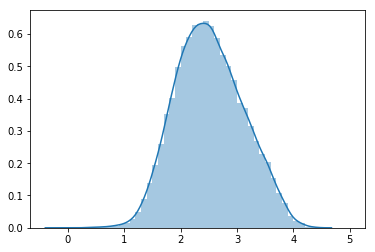

In [105]:
plot_pred(oof_train)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


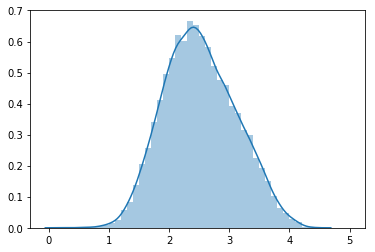

In [106]:
plot_pred(oof_train_xgb)

In [107]:
oof_train.shape

(14993,)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


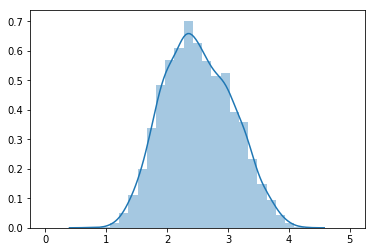

In [108]:
plot_pred(oof_test.mean(axis=1))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


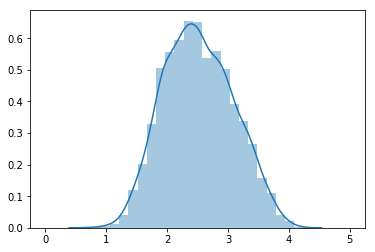

In [109]:
plot_pred(oof_test_xgb.mean(1))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


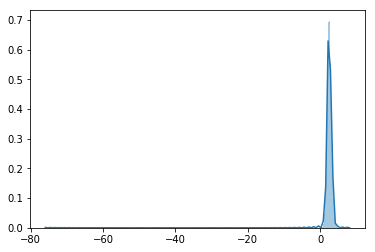

In [110]:
plot_pred(trainer.train_preds * 4)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


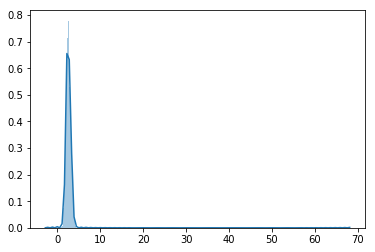

In [111]:
plot_pred(test_preds * 4)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


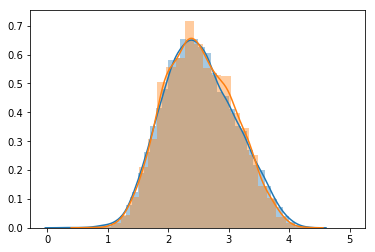

In [112]:
lgb_xgb = 0.5 * oof_train + 0.5 * oof_train_xgb
lgb_xgb_test = 0.5 * oof_test.mean(1) + 0.5 * oof_test_xgb.mean(1)
plot_pred(lgb_xgb)
plot_pred(lgb_xgb_test)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


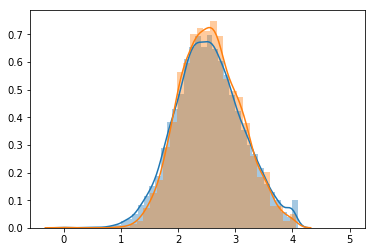

In [113]:
nn_preds = np.clip(trainer.train_preds, a_min=0.0, a_max=1.0)
nn_preds_test = np.clip(test_preds, a_min=0.0, a_max=1.0)
plot_pred(nn_preds * 4)
plot_pred(nn_preds_test * 4)

In [114]:
lgb_xgb_nn = 0.9 * lgb_xgb + 0.1 * (nn_preds * 4)
lgb_xgb_nn_test = 0.9 * lgb_xgb_test + 0.1 * nn_preds_test * 4

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


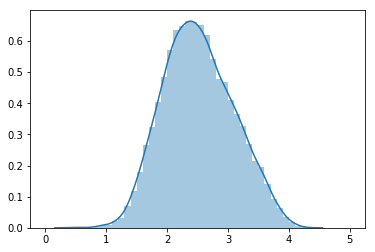

In [115]:
plot_pred(lgb_xgb_nn)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


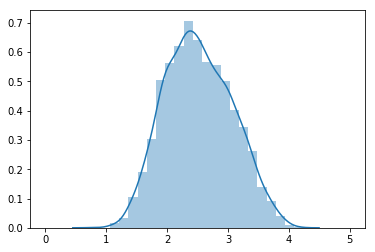

In [116]:
plot_pred(lgb_xgb_nn_test)

In [117]:
opt = OptimizedRounder()
opt.fit(lgb_xgb, target, [1.6, 2.1, 2.8, 3.5])
coeff = opt.coefficients()
valid_pred = opt.predict(lgb_xgb, coeff)
qwk = quadratic_weighted_kappa(xgb_y, valid_pred)
print("QWK = ", qwk)
coeffs = coeff.copy()
train_predictions = opt.predict(lgb_xgb, coeffs).astype(np.int8)
print(f"train_preds: {Counter(train_predictions)}")
test_predictions = opt.predict(lgb_xgb_test, coeffs).astype(np.int8)
print(f"test_preds: {Counter(test_predictions)}")
submission = pd.DataFrame({"PetID": test.PetID.values, "AdoptionSpeed": test_predictions})
submission.to_csv("submission_tree.csv", index=False)
submission.head()

QWK =  0.5097558466762209
train_preds: Counter({2: 4719, 3: 3597, 4: 3569, 1: 2560, 0: 548})
test_preds: Counter({2: 1219, 3: 959, 4: 944, 1: 714, 0: 112})


,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,3
2,72000c4c5,3
3,e147a4b9f,2
4,43fbba852,4


In [118]:
opt = OptimizedRounder()
opt.fit(lgb_xgb_nn, target, [1.5, 2.0, 2.5, 3.5])
coeff = opt.coefficients()
valid_pred = opt.predict(lgb_xgb_nn, coeff)
qwk = quadratic_weighted_kappa(xgb_y, valid_pred)
print("QWK = ", qwk)
coeffs = coeff.copy()
train_predictions = opt.predict(lgb_xgb_nn, coeffs).astype(np.int8)
print(f"train_preds: {Counter(train_predictions)}")
test_predictions = opt.predict(lgb_xgb_nn_test, coeffs).astype(np.int8)
print(f"test_preds: {Counter(test_predictions)}")
submission = pd.DataFrame({"PetID": test.PetID.values, "AdoptionSpeed": test_predictions})
submission.to_csv("submission.csv", index=False)
submission.head()

QWK =  0.5101740262012959
train_preds: Counter({2: 4664, 3: 3458, 4: 3146, 1: 3092, 0: 633})
test_preds: Counter({2: 1214, 3: 935, 1: 849, 4: 819, 0: 131})


,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,3
2,72000c4c5,3
3,e147a4b9f,2
4,43fbba852,4


In [ ]:
opt = OptimizedRounder()
opt.fit(nn_preds * 4, target, [1.5, 2.0, 2.5, 3.5])
coeff = opt.coefficients()
valid_pred = opt.predict(nn_preds * 4, coeff)
qwk = quadratic_weighted_kappa(target, valid_pred)
print("QWK = ", qwk)
coeffs = coeff.copy()
train_predictions = opt.predict(nn_preds * 4, coeffs).astype(np.int8)
print(f"train_preds: {Counter(train_predictions)}")
test_predictions = opt.predict(nn_preds_test * 4, coeffs).astype(np.int8)
print(f"test_preds: {Counter(test_predictions)}")
submission = pd.DataFrame({"PetID": test.PetID.values, "AdoptionSpeed": test_predictions})
submission.to_csv("submission_nn.csv", index=False)
submission.head()